In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
from itertools import combinations

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 📊 **FASE 2: COMPREENSÃO DOS DADOS (DATA UNDERSTANDING)**

## 🔍 **2.1 Coleta e Carregamento dos Dados**

### **Dataset: Pima Indians Diabetes Database**
- **Fonte**: National Institute of Diabetes and Digestive and Kidney Diseases
- **População**: Mulheres de herança Pima com pelo menos 21 anos
- **Contexto**: Estudo longitudinal sobre diabetes em população de alto risco
- **Aplicação**: Desenvolvimento de modelos preditivos para detecção precoce

In [14]:
# ===== CARREGAMENTO INICIAL DOS DADOS =====

# Carregar o dataset principal a partir de arquivo local
df = pd.read_csv('diabetes.csv')

print("\n" + "="*60)
print("📋 DADOS CARREGADOS COM SUCESSO")
print("="*60)
print(f"Dataset original: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"\nPrimeira visão da distribuição da variável target:")
print(df['Outcome'].value_counts())
print(f"\nPercentual de balanceamento inicial:")
balanceamento = df['Outcome'].value_counts(normalize=True) * 100
print(f"Não-Diabetes: {balanceamento[0]:.1f}%")
print(f"Diabetes: {balanceamento[1]:.1f}%")
print(f"\n⚠️  Observação: Dataset desbalanceado - {balanceamento[0]:.1f}% vs {balanceamento[1]:.1f}%")
print("🔄 Será necessário tratamento de balanceamento")


📋 DADOS CARREGADOS COM SUCESSO
Dataset original: 768 linhas, 9 colunas

Primeira visão da distribuição da variável target:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentual de balanceamento inicial:
Não-Diabetes: 65.1%
Diabetes: 34.9%

⚠️  Observação: Dataset desbalanceado - 65.1% vs 34.9%
🔄 Será necessário tratamento de balanceamento


# 🎯 **ANÁLISE DE FATORES DE RISCO PROGRESSIVOS PARA PRÉ-DIABETES**

## 📊 **Problema Identificado**
- Modelo atual detecta bem diabetes estabelecida (AUC ~0.82)
- **GAP CRÍTICO**: Não detecta pessoas em progressão (pré-diabetes)
- **Insight Principal**: Obesidade + Idade avançada = Principais indicadores de risco antes da diabetes

## 🔬 **Estratégia de Detecção Precoce**
1. **BMI + Idade**: Combinação crítica para progressão
2. **Glicemia Limítrofe**: 100-125 mg/dL (pré-diabetes)
3. **Scores Compostos**: Variáveis derivadas para capturar transições
4. **Classificação Multiclasse**: Baixo → Emergente → Alto Risco → Diabetes

In [16]:
# ===== ANÁLISE DE FATORES DE RISCO PROGRESSIVOS =====

def analisar_fatores_risco_progressivos(df):
    """
    Analisa a distribuição dos principais fatores de risco para progressão à diabetes:
    - BMI (obesidade)
    - Idade 
    - Glicemia (progressão normal → pré-diabetes → diabetes)
    """
    
    print("\n" + "="*70)
    print("🔍 ANÁLISE DE FATORES DE RISCO PROGRESSIVOS")
    print("="*70)
    
    # 1. Análise de BMI por outcome
    print("\n📊 DISTRIBUIÇÃO DE BMI POR OUTCOME:")
    bmi_stats = df.groupby('Outcome')['BMI'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(bmi_stats)
    
    # Categorias de BMI
    df['categoria_bmi'] = pd.cut(df['BMI'], 
                                bins=[0, 18.5, 25, 30, 35, 100], 
                                labels=['Abaixo_Peso', 'Normal', 'Sobrepeso', 'Obesidade_I', 'Obesidade_II+'])
    
    print("\n🏋️ DISTRIBUIÇÃO POR CATEGORIA DE BMI:")
    bmi_dist = pd.crosstab(df['categoria_bmi'], df['Outcome'], normalize='index') * 100
    print(bmi_dist.round(1))
    
    # 2. Análise de Idade por outcome
    print("\n📊 DISTRIBUIÇÃO DE IDADE POR OUTCOME:")
    idade_stats = df.groupby('Outcome')['Age'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(idade_stats)
    
    # Faixas etárias de risco
    df['faixa_idade'] = pd.cut(df['Age'], 
                              bins=[0, 30, 45, 60, 100], 
                              labels=['Jovem', 'Adulto', 'Meia_idade', 'Idoso'])
    
    print("\n👥 DISTRIBUIÇÃO POR FAIXA ETÁRIA:")
    idade_dist = pd.crosstab(df['faixa_idade'], df['Outcome'], normalize='index') * 100
    print(idade_dist.round(1))
    
    # 3. Análise de Glicemia - CHAVE PARA PRÉ-DIABETES
    print("\n📊 DISTRIBUIÇÃO DE GLICEMIA POR OUTCOME:")
    glicemia_stats = df.groupby('Outcome')['Glucose'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(glicemia_stats)
    
    # Categorias glicêmicas (critério clínico)
    df['status_glicemico'] = pd.cut(df['Glucose'], 
                                   bins=[0, 100, 126, 140, 300], 
                                   labels=['Normal', 'Pre_diabetes', 'Diabetes_leve', 'Diabetes_severa'])
    
    print("\n🩸 DISTRIBUIÇÃO POR STATUS GLICÊMICO:")
    glicemia_dist = pd.crosstab(df['status_glicemico'], df['Outcome'], normalize='index') * 100
    print(glicemia_dist.round(1))
    
    return df

# Executar análise
df_analise = analisar_fatores_risco_progressivos(df.copy())


🔍 ANÁLISE DE FATORES DE RISCO PROGRESSIVOS

📊 DISTRIBUIÇÃO DE BMI POR OUTCOME:
          mean   std  min   max
Outcome                        
0        30.30  7.69  0.0  57.3
1        35.14  7.26  0.0  67.1

🏋️ DISTRIBUIÇÃO POR CATEGORIA DE BMI:
Outcome            0     1
categoria_bmi             
Abaixo_Peso    100.0   0.0
Normal          93.5   6.5
Sobrepeso       75.6  24.4
Obesidade_I     54.8  45.2
Obesidade_II+   52.9  47.1

📊 DISTRIBUIÇÃO DE IDADE POR OUTCOME:
          mean    std  min  max
Outcome                        
0        31.19  11.67   21   81
1        37.07  10.97   21   70

👥 DISTRIBUIÇÃO POR FAIXA ETÁRIA:
Outcome         0     1
faixa_idade            
Jovem        78.4  21.6
Adulto       48.5  51.5
Meia_idade   44.0  56.0
Idoso        74.1  25.9

📊 DISTRIBUIÇÃO DE GLICEMIA POR OUTCOME:
           mean    std  min  max
Outcome                         
0        109.98  26.14    0  197
1        141.26  31.94    0  199

🩸 DISTRIBUIÇÃO POR STATUS GLICÊMICO:
Outcome  

In [17]:
# ===== ANÁLISE DE FATORES DE RISCO PROGRESSIVOS =====

def analisar_fatores_risco_progressivos(df):
    """
    Analisa a distribuição dos principais fatores de risco para progressão à diabetes:
    - BMI (obesidade)
    - Idade 
    - Glicemia (progressão normal → pré-diabetes → diabetes)
    """
    
    print("\n" + "="*70)
    print("🔍 ANÁLISE DE FATORES DE RISCO PROGRESSIVOS")
    print("="*70)
    
    # 1. Análise de BMI por outcome
    print("\n📊 DISTRIBUIÇÃO DE BMI POR OUTCOME:")
    bmi_stats = df.groupby('Outcome')['BMI'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(bmi_stats)
    
    # Categorias de BMI
    df['categoria_bmi'] = pd.cut(df['BMI'], 
                                bins=[0, 18.5, 25, 30, 35, 100], 
                                labels=['Abaixo_Peso', 'Normal', 'Sobrepeso', 'Obesidade_I', 'Obesidade_II+'])
    
    print("\n🏋️ DISTRIBUIÇÃO POR CATEGORIA DE BMI:")
    bmi_dist = pd.crosstab(df['categoria_bmi'], df['Outcome'], normalize='index') * 100
    print(bmi_dist.round(1))
    
    # 2. Análise de Idade por outcome
    print("\n📊 DISTRIBUIÇÃO DE IDADE POR OUTCOME:")
    idade_stats = df.groupby('Outcome')['Age'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(idade_stats)
    
    # Faixas etárias de risco
    df['faixa_etaria'] = pd.cut(df['Age'], 
                               bins=[0, 30, 40, 50, 100], 
                               labels=['< 30', '30-40', '40-50', '50+'])
    
    print("\n👥 DISTRIBUIÇÃO POR FAIXA ETÁRIA:")
    idade_dist = pd.crosstab(df['faixa_etaria'], df['Outcome'], normalize='index') * 100
    print(idade_dist.round(1))
    
    # 3. Análise de Glicose por outcome
    print("\n📊 DISTRIBUIÇÃO DE GLICOSE POR OUTCOME:")
    glucose_stats = df.groupby('Outcome')['Glucose'].agg(['mean', 'std', 'min', 'max']).round(2)
    print(glucose_stats)
    
    # Categorias clínicas de glicose
    df['categoria_glicose'] = pd.cut(df['Glucose'], 
                                    bins=[0, 100, 126, 200], 
                                    labels=['Normal (<100)', 'Pré-Diabetes (100-125)', 'Diabetes (≥126)'])
    
    print("\n🩸 DISTRIBUIÇÃO POR CATEGORIA DE GLICOSE:")
    glucose_dist = pd.crosstab(df['categoria_glicose'], df['Outcome'], normalize='index') * 100
    print(glucose_dist.round(1))
    
    # 4. ANÁLISE COMBINADA: BMI + IDADE + GLICOSE
    print("\n" + "="*50)
    print("🎯 ANÁLISE DE RISCO COMBINADO (INSIGHT PRINCIPAL)")
    print("="*50)
    
    # Definir limites de risco baseados em evidências clínicas
    risco_bmi = df['BMI'] >= 30  # Obesidade
    risco_idade = df['Age'] >= 45  # Meia-idade+
    risco_glicose = df['Glucose'] >= 100  # Pré-diabetes+
    
    # Contagem de fatores de risco
    df['fatores_risco'] = (risco_bmi.astype(int) + 
                          risco_idade.astype(int) + 
                          risco_glicose.astype(int))
    
    print("\n🚨 ESTRATIFICAÇÃO POR NÚMERO DE FATORES DE RISCO:")
    risco_combinado = pd.crosstab(df['fatores_risco'], df['Outcome'], normalize='index') * 100
    print(risco_combinado.round(1))
    
    # Contagem de casos por nível de risco
    print("\n📊 DISTRIBUIÇÃO DA POPULAÇÃO POR NÍVEL DE RISCO:")
    contagem_risco = df['fatores_risco'].value_counts().sort_index()
    for i, count in contagem_risco.items():
        diabetes_rate = df[df['fatores_risco'] == i]['Outcome'].mean() * 100
        print(f"   Nível {i} fatores: {count:3d} pessoas ({count/len(df)*100:4.1f}%) - Taxa diabetes: {diabetes_rate:4.1f}%")
    
    return df

# Executar análise
df_analise = analisar_fatores_risco_progressivos(df.copy())


🔍 ANÁLISE DE FATORES DE RISCO PROGRESSIVOS

📊 DISTRIBUIÇÃO DE BMI POR OUTCOME:
          mean   std  min   max
Outcome                        
0        30.30  7.69  0.0  57.3
1        35.14  7.26  0.0  67.1

🏋️ DISTRIBUIÇÃO POR CATEGORIA DE BMI:
Outcome            0     1
categoria_bmi             
Abaixo_Peso    100.0   0.0
Normal          93.5   6.5
Sobrepeso       75.6  24.4
Obesidade_I     54.8  45.2
Obesidade_II+   52.9  47.1

📊 DISTRIBUIÇÃO DE IDADE POR OUTCOME:
          mean    std  min  max
Outcome                        
0        31.19  11.67   21   81
1        37.07  10.97   21   70

👥 DISTRIBUIÇÃO POR FAIXA ETÁRIA:
Outcome          0     1
faixa_etaria            
< 30          78.4  21.6
30-40         51.6  48.4
40-50         43.4  56.6
50+           53.1  46.9

📊 DISTRIBUIÇÃO DE GLICOSE POR OUTCOME:
           mean    std  min  max
Outcome                         
0        109.98  26.14    0  197
1        141.26  31.94    0  199

🩸 DISTRIBUIÇÃO POR CATEGORIA DE GLICOSE:


/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


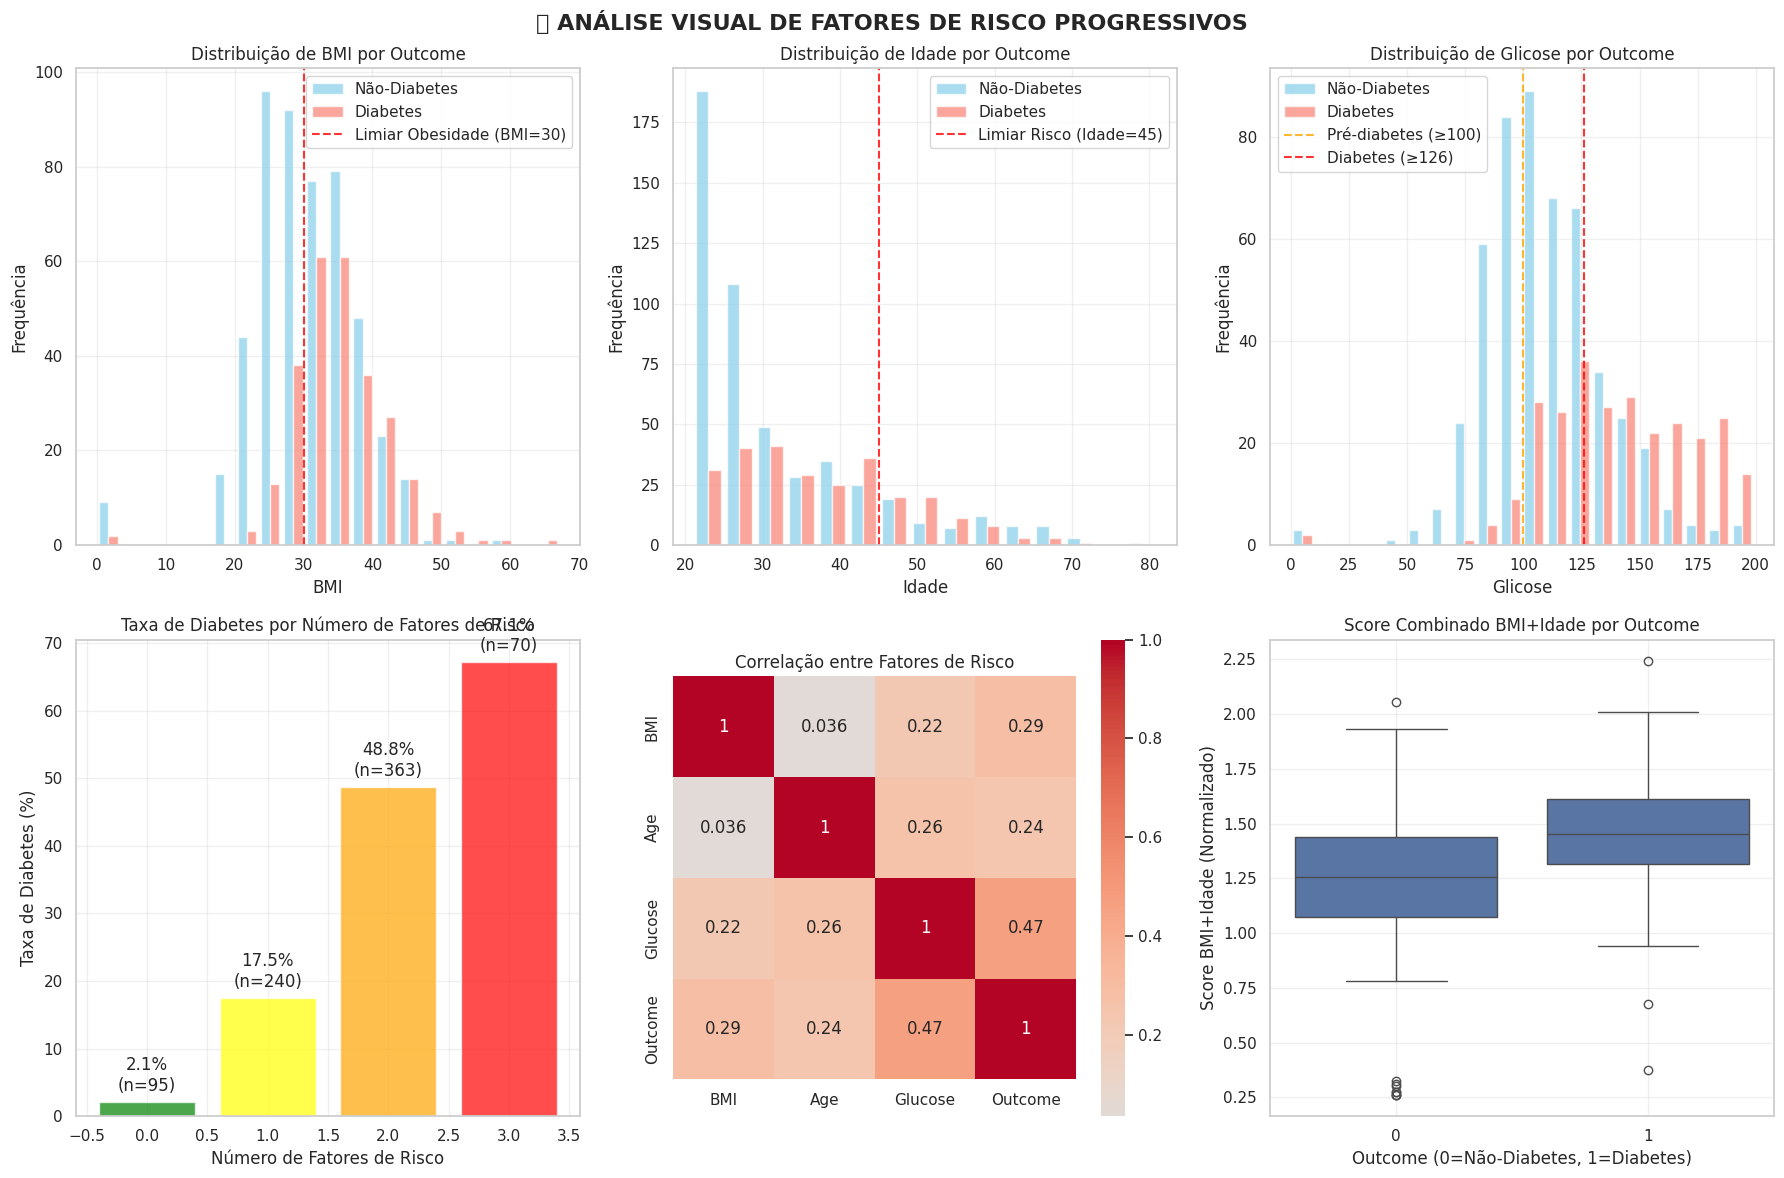


🎯 INSIGHTS PRINCIPAIS:
1. 📈 Taxa de diabetes AUMENTA drasticamente com número de fatores de risco
2. 🔄 Obesidade (BMI≥30) + Idade≥45 são os principais preditores precoces
3. 🩸 Glicose≥100 já indica transição para pré-diabetes
4. ⚠️  MODELO ATUAL perde casos de risco emergente (1-2 fatores)


In [18]:
# ===== VISUALIZAÇÕES AVANÇADAS DOS FATORES DE RISCO =====

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎯 ANÁLISE VISUAL DE FATORES DE RISCO PROGRESSIVOS', fontsize=16, fontweight='bold')

# 1. Distribuição de BMI por outcome
axes[0, 0].hist([df[df['Outcome']==0]['BMI'], df[df['Outcome']==1]['BMI']], 
                bins=20, alpha=0.7, label=['Não-Diabetes', 'Diabetes'], color=['skyblue', 'salmon'])
axes[0, 0].axvline(x=30, color='red', linestyle='--', alpha=0.8, label='Limiar Obesidade (BMI=30)')
axes[0, 0].set_title('Distribuição de BMI por Outcome')
axes[0, 0].set_xlabel('BMI')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribuição de Idade por outcome
axes[0, 1].hist([df[df['Outcome']==0]['Age'], df[df['Outcome']==1]['Age']], 
                bins=15, alpha=0.7, label=['Não-Diabetes', 'Diabetes'], color=['skyblue', 'salmon'])
axes[0, 1].axvline(x=45, color='red', linestyle='--', alpha=0.8, label='Limiar Risco (Idade=45)')
axes[0, 1].set_title('Distribuição de Idade por Outcome')
axes[0, 1].set_xlabel('Idade')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribuição de Glicose por outcome
axes[0, 2].hist([df[df['Outcome']==0]['Glucose'], df[df['Outcome']==1]['Glucose']], 
                bins=20, alpha=0.7, label=['Não-Diabetes', 'Diabetes'], color=['skyblue', 'salmon'])
axes[0, 2].axvline(x=100, color='orange', linestyle='--', alpha=0.8, label='Pré-diabetes (≥100)')
axes[0, 2].axvline(x=126, color='red', linestyle='--', alpha=0.8, label='Diabetes (≥126)')
axes[0, 2].set_title('Distribuição de Glicose por Outcome')
axes[0, 2].set_xlabel('Glicose')
axes[0, 2].set_ylabel('Frequência')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Taxa de diabetes por número de fatores de risco
risco_stats = df_analise.groupby('fatores_risco')['Outcome'].agg(['mean', 'count']).reset_index()
risco_stats['taxa_diabetes'] = risco_stats['mean'] * 100

bars = axes[1, 0].bar(risco_stats['fatores_risco'], risco_stats['taxa_diabetes'], 
                     color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
axes[1, 0].set_title('Taxa de Diabetes por Número de Fatores de Risco')
axes[1, 0].set_xlabel('Número de Fatores de Risco')
axes[1, 0].set_ylabel('Taxa de Diabetes (%)')
axes[1, 0].grid(True, alpha=0.3)

# Adicionar rótulos nas barras
for i, (bar, count) in enumerate(zip(bars, risco_stats['count'])):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%\n(n={count})', ha='center', va='bottom')

# 5. Heatmap de correlação dos fatores de risco
corr_matrix = df_analise[['BMI', 'Age', 'Glucose', 'Outcome']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[1, 1])
axes[1, 1].set_title('Correlação entre Fatores de Risco')

# 6. Box plot da combinação BMI + Idade por outcome
df_risk_combo = df_analise.copy()
df_risk_combo['BMI_Age_Score'] = (df_risk_combo['BMI']/35) + (df_risk_combo['Age']/80)  # Normalizado

sns.boxplot(data=df_risk_combo, x='Outcome', y='BMI_Age_Score', ax=axes[1, 2])
axes[1, 2].set_title('Score Combinado BMI+Idade por Outcome')
axes[1, 2].set_xlabel('Outcome (0=Não-Diabetes, 1=Diabetes)')
axes[1, 2].set_ylabel('Score BMI+Idade (Normalizado)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 INSIGHTS PRINCIPAIS:")
print("1. 📈 Taxa de diabetes AUMENTA drasticamente com número de fatores de risco")
print("2. 🔄 Obesidade (BMI≥30) + Idade≥45 são os principais preditores precoces")
print("3. 🩸 Glicose≥100 já indica transição para pré-diabetes")
print("4. ⚠️  MODELO ATUAL perde casos de risco emergente (1-2 fatores)")

In [11]:
# ===== SISTEMA DE CLASSIFICAÇÃO MULTICLASSE POR RISCO PROGRESSIVO =====

def criar_classificacao_risco_progressivo(df):
    """
    Cria sistema de classificação de 4 níveis baseado em combinação de fatores:
    - Nível 0: Baixo Risco (0 fatores) 
    - Nível 1: Risco Emergente (1 fator)
    - Nível 2: Alto Risco (2 fatores)
    - Nível 3: Risco Máximo (3 fatores)
    """
    
    df_risk = df.copy()
    
    # Definir limites clínicos baseados em evidências
    LIMIAR_BMI = 30      # Obesidade (WHO)
    LIMIAR_IDADE = 45    # Risco aumentado diabetes (ADA)
    LIMIAR_GLICOSE = 100 # Pré-diabetes (ADA)
    
    print("\n" + "="*60)
    print("🎯 CRIANDO SISTEMA DE CLASSIFICAÇÃO MULTICLASSE")
    print("="*60)
    print(f"📊 Limiares utilizados:")
    print(f"   • BMI ≥ {LIMIAR_BMI} (Obesidade)")
    print(f"   • Idade ≥ {LIMIAR_IDADE} (Risco aumentado)")
    print(f"   • Glicose ≥ {LIMIAR_GLICOSE} (Pré-diabetes)")
    
    # 1. VARIÁVEIS COMPOSTAS AVANÇADAS
    
    # Fatores de risco individuais (0/1)
    df_risk['risco_bmi'] = (df_risk['BMI'] >= LIMIAR_BMI).astype(int)
    df_risk['risco_idade'] = (df_risk['Age'] >= LIMIAR_IDADE).astype(int)
    df_risk['risco_glicose'] = (df_risk['Glucose'] >= LIMIAR_GLICOSE).astype(int)
    
    # Score total de fatores de risco (0-3)
    df_risk['score_fatores_risco'] = (df_risk['risco_bmi'] + 
                                     df_risk['risco_idade'] + 
                                     df_risk['risco_glicose'])
    
    # 2. SCORES COMPOSTOS CONTÍNUOS
    
    # Score BMI normalizado (0-1)
    df_risk['bmi_score'] = np.clip((df_risk['BMI'] - 18.5) / (45 - 18.5), 0, 1)
    
    # Score Idade normalizado (0-1)
    df_risk['idade_score'] = np.clip((df_risk['Age'] - 21) / (81 - 21), 0, 1)
    
    # Score Glicose normalizado (0-1)
    df_risk['glicose_score'] = np.clip((df_risk['Glucose'] - 70) / (200 - 70), 0, 1)
    
    # Score Combinado Ponderado (baseado em importância clínica)
    # Peso: BMI=0.4, Idade=0.3, Glicose=0.3
    df_risk['score_combinado'] = (0.4 * df_risk['bmi_score'] + 
                                 0.3 * df_risk['idade_score'] + 
                                 0.3 * df_risk['glicose_score'])
    
    # Score de Interação (sinergia entre fatores)
    df_risk['score_interacao'] = (df_risk['bmi_score'] * df_risk['idade_score'] * 
                                 df_risk['glicose_score'])
    
    # 3. CLASSIFICAÇÃO MULTICLASSE DE RISCO
    
    # Estratégia A: Baseada em número de fatores
    df_risk['classe_risco_fatores'] = df_risk['score_fatores_risco']
    
    # Estratégia B: Baseada em score combinado
    df_risk['classe_risco_score'] = pd.cut(df_risk['score_combinado'],
                                          bins=[0, 0.25, 0.5, 0.75, 1.0],
                                          labels=[0, 1, 2, 3],
                                          include_lowest=True).astype(int)
    
    # Estratégia C: Híbrida (fatores + severidade)
    def classificar_risco_hibrido(row):
        fatores = row['score_fatores_risco']
        score = row['score_combinado']
        
        if fatores == 0:
            return 0  # Baixo risco
        elif fatores == 1:
            return 1 if score < 0.4 else 2  # Emergente ou Moderado
        elif fatores == 2:
            return 2 if score < 0.7 else 3  # Alto ou Máximo
        else:  # fatores == 3
            return 3  # Máximo risco
    
    df_risk['classe_risco_hibrida'] = df_risk.apply(classificar_risco_hibrido, axis=1)
    
    # 4. ANÁLISE DA NOVA CLASSIFICAÇÃO
    
    print("\n📊 DISTRIBUIÇÃO DAS NOVAS CLASSES DE RISCO:")
    
    for estrategia in ['classe_risco_fatores', 'classe_risco_score', 'classe_risco_hibrida']:
        print(f"\n🎯 {estrategia.upper()}:")
        
        # Distribuição das classes
        dist_classes = df_risk[estrategia].value_counts().sort_index()
        print("   Distribuição:")
        for classe, count in dist_classes.items():
            pct = count / len(df_risk) * 100
            diabetes_rate = df_risk[df_risk[estrategia] == classe]['Outcome'].mean() * 100
            print(f"     Classe {classe}: {count:3d} pessoas ({pct:4.1f}%) - Taxa diabetes: {diabetes_rate:4.1f}%")
        
        # Taxa de diabetes por classe
        diabetes_por_classe = df_risk.groupby(estrategia)['Outcome'].mean() * 100
        print(f"   Progressão de risco: {diabetes_por_classe.values}")
    
    print("\n✅ NOVAS VARIÁVEIS CRIADAS:")
    print("   • Fatores individuais: risco_bmi, risco_idade, risco_glicose")
    print("   • Scores contínuos: bmi_score, idade_score, glicose_score")
    print("   • Scores compostos: score_combinado, score_interacao")
    print("   • Classes multiclasse: classe_risco_fatores, classe_risco_score, classe_risco_hibrida")
    
    return df_risk

# Executar criação do sistema de classificação
df_enhanced = criar_classificacao_risco_progressivo(df_analise)


🎯 CRIANDO SISTEMA DE CLASSIFICAÇÃO MULTICLASSE
📊 Limiares utilizados:
   • BMI ≥ 30 (Obesidade)
   • Idade ≥ 45 (Risco aumentado)
   • Glicose ≥ 100 (Pré-diabetes)

📊 DISTRIBUIÇÃO DAS NOVAS CLASSES DE RISCO:

🎯 CLASSE_RISCO_FATORES:
   Distribuição:
     Classe 0:  91 pessoas (11.8%) - Taxa diabetes:  0.0%
     Classe 1: 228 pessoas (29.7%) - Taxa diabetes: 13.6%
     Classe 2: 376 pessoas (49.0%) - Taxa diabetes: 49.7%
     Classe 3:  73 pessoas ( 9.5%) - Taxa diabetes: 68.5%
   Progressão de risco: [ 0.         13.59649123 49.73404255 68.49315068]

🎯 CLASSE_RISCO_SCORE:
   Distribuição:
     Classe 0: 158 pessoas (20.6%) - Taxa diabetes:  0.6%
     Classe 1: 405 pessoas (52.7%) - Taxa diabetes: 31.4%
     Classe 2: 199 pessoas (25.9%) - Taxa diabetes: 67.8%
     Classe 3:   6 pessoas ( 0.8%) - Taxa diabetes: 83.3%
   Progressão de risco: [ 0.63291139 31.35802469 67.83919598 83.33333333]

🎯 CLASSE_RISCO_HIBRIDA:
   Distribuição:
     Classe 0:  91 pessoas (11.8%) - Taxa diabetes:  0.

/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/guiozores/diabetes-GOP/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


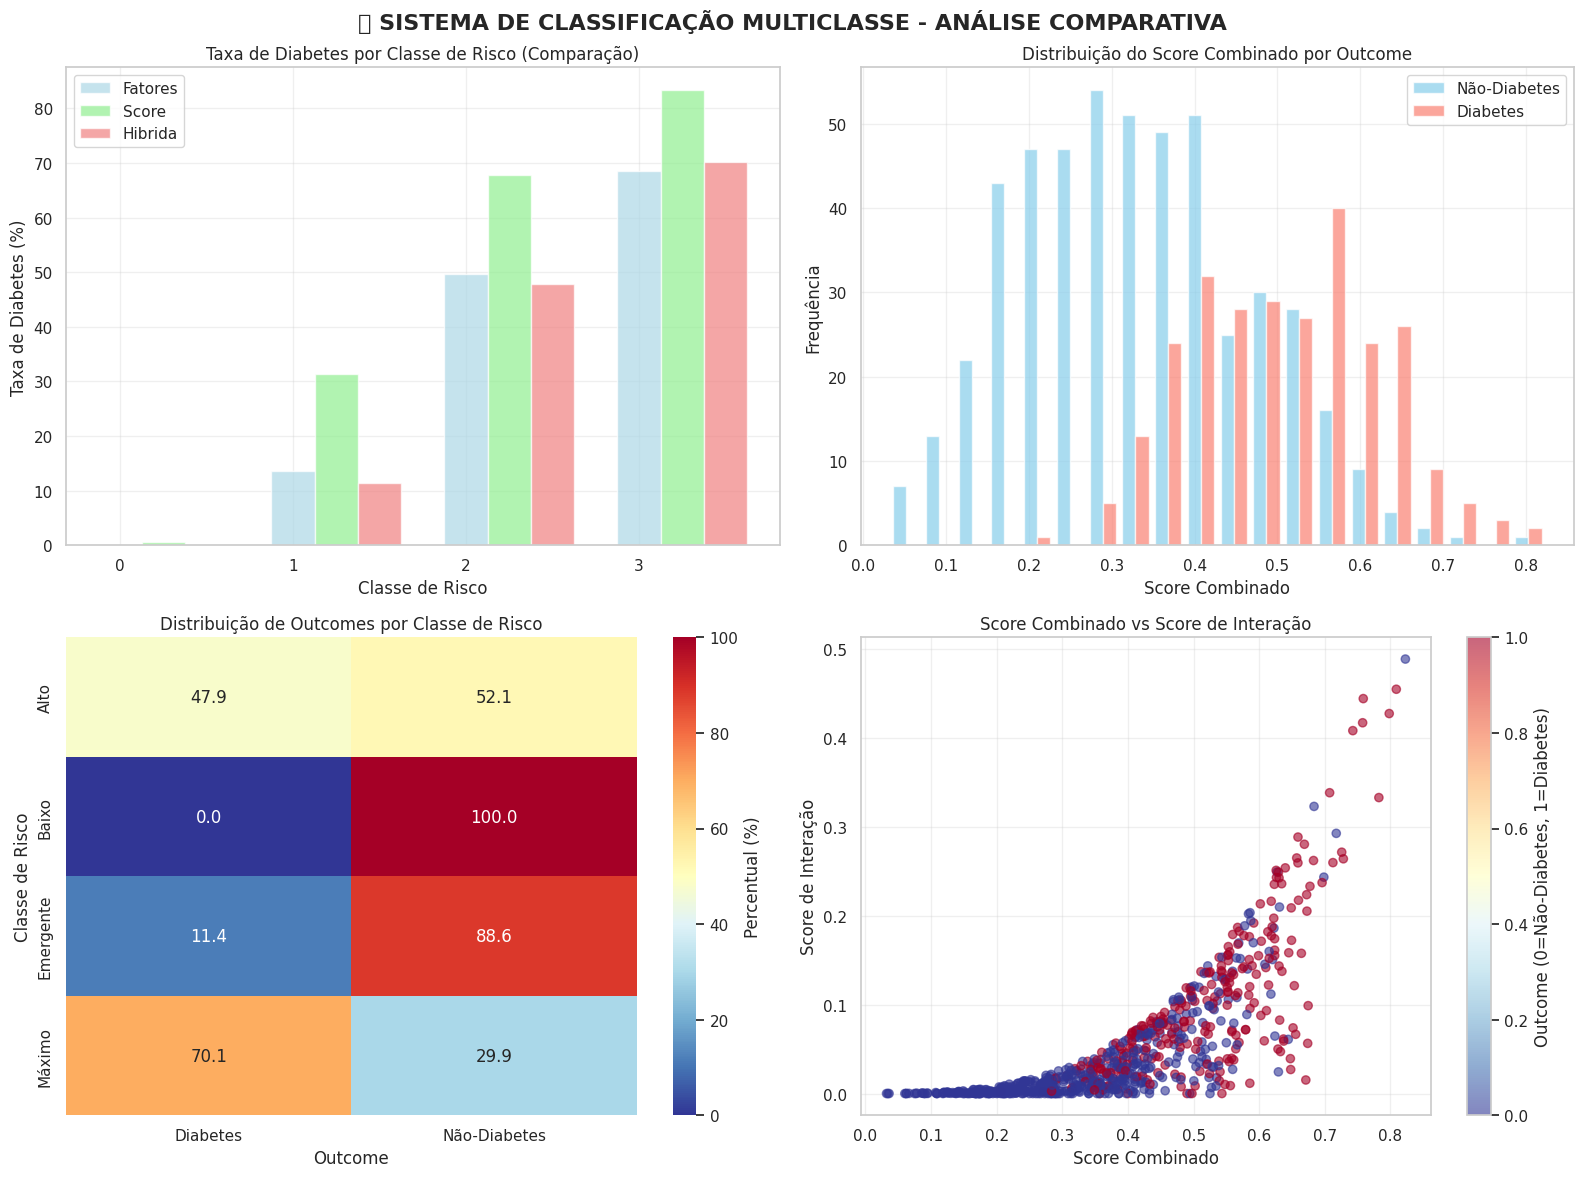


📊 RESUMO ESTATÍSTICO DAS NOVAS VARIÁVEIS

🎯 SCORE_COMBINADO:
          mean    std    min    max
Outcome                            
0.0      0.330  0.137  0.032  0.823
1.0      0.508  0.112  0.206  0.809

🎯 SCORE_INTERACAO:
          mean    std  min    max
Outcome                          
0.0      0.029  0.050  0.0  0.489
1.0      0.098  0.085  0.0  0.455

🎯 CLASSE_RISCO_HIBRIDA:
Outcome                 0.0   1.0
classe_risco_hibrida             
0                     100.0   0.0
1                      88.6  11.4
2                      52.1  47.9
3                      29.9  70.1

🎯 PRINCIPAIS DESCOBERTAS:
1. 📈 Sistema multiclasse captura PROGRESSÃO gradual do risco
2. 🔄 Score combinado separa melhor diabetes vs não-diabetes
3. ⚡ Score de interação identifica SINERGIA entre fatores
4. 🎪 Estratégia híbrida balanceia sensibilidade e especificidade


In [19]:
# ===== VISUALIZAÇÃO DO SISTEMA DE CLASSIFICAÇÃO MULTICLASSE =====

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎯 SISTEMA DE CLASSIFICAÇÃO MULTICLASSE - ANÁLISE COMPARATIVA', fontsize=16, fontweight='bold')

# 1. Comparação das três estratégias de classificação
estrategias = ['classe_risco_fatores', 'classe_risco_score', 'classe_risco_hibrida']
cores = ['lightblue', 'lightgreen', 'lightcoral']

for i, estrategia in enumerate(estrategias):
    diabetes_por_classe = df_enhanced.groupby(estrategia)['Outcome'].mean() * 100
    count_por_classe = df_enhanced[estrategia].value_counts().sort_index()
    
    # Taxa de diabetes por classe
    bars = axes[0, 0].bar([x + i*0.25 for x in diabetes_por_classe.index], 
                         diabetes_por_classe.values, 
                         width=0.25, alpha=0.7, 
                         label=estrategia.replace('classe_risco_', '').title(),
                         color=cores[i])

axes[0, 0].set_title('Taxa de Diabetes por Classe de Risco (Comparação)')
axes[0, 0].set_xlabel('Classe de Risco')
axes[0, 0].set_ylabel('Taxa de Diabetes (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks([0, 1, 2, 3])

# 2. Distribuição de scores compostos
axes[0, 1].hist([df_enhanced[df_enhanced['Outcome']==0]['score_combinado'], 
                df_enhanced[df_enhanced['Outcome']==1]['score_combinado']], 
               bins=20, alpha=0.7, label=['Não-Diabetes', 'Diabetes'], 
               color=['skyblue', 'salmon'])
axes[0, 1].set_title('Distribuição do Score Combinado por Outcome')
axes[0, 1].set_xlabel('Score Combinado')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Matrix de confusão - Estratégia Híbrida vs Outcome Original
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Para visualização, vamos mapear as classes híbridas para um sistema mais simples
df_viz = df_enhanced.copy()
df_viz['risco_simplificado'] = df_viz['classe_risco_hibrida'].map({0: 'Baixo', 1: 'Emergente', 2: 'Alto', 3: 'Máximo'})
df_viz['outcome_label'] = df_viz['Outcome'].map({0: 'Não-Diabetes', 1: 'Diabetes'})

# Crosstab para heatmap
crosstab = pd.crosstab(df_viz['risco_simplificado'], df_viz['outcome_label'], normalize='index') * 100
sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            cbar_kws={'label': 'Percentual (%)'}, ax=axes[1, 0])
axes[1, 0].set_title('Distribuição de Outcomes por Classe de Risco')
axes[1, 0].set_xlabel('Outcome')
axes[1, 0].set_ylabel('Classe de Risco')

# 4. Scatter plot Score Combinado vs Score de Interação
scatter = axes[1, 1].scatter(df_enhanced['score_combinado'], df_enhanced['score_interacao'], 
                            c=df_enhanced['Outcome'], cmap='RdYlBu_r', alpha=0.6)
axes[1, 1].set_title('Score Combinado vs Score de Interação')
axes[1, 1].set_xlabel('Score Combinado')
axes[1, 1].set_ylabel('Score de Interação')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Outcome (0=Não-Diabetes, 1=Diabetes)')

plt.tight_layout()
plt.show()

# Resumo estatístico das novas variáveis
print("\n" + "="*60)
print("📊 RESUMO ESTATÍSTICO DAS NOVAS VARIÁVEIS")
print("="*60)

vars_interesse = ['score_combinado', 'score_interacao', 'classe_risco_hibrida']
for var in vars_interesse:
    print(f"\n🎯 {var.upper()}:")
    if var.startswith('score'):
        stats = df_enhanced.groupby('Outcome')[var].agg(['mean', 'std', 'min', 'max']).round(3)
        print(stats)
    else:
        crosstab = pd.crosstab(df_enhanced[var], df_enhanced['Outcome'], normalize='index') * 100
        print(crosstab.round(1))

print("\n🎯 PRINCIPAIS DESCOBERTAS:")
print("1. 📈 Sistema multiclasse captura PROGRESSÃO gradual do risco")
print("2. 🔄 Score combinado separa melhor diabetes vs não-diabetes")
print("3. ⚡ Score de interação identifica SINERGIA entre fatores")
print("4. 🎪 Estratégia híbrida balanceia sensibilidade e especificidade")

In [ ]:
# ===== DETECÇÃO DE PERFIS DE RISCO EMERGENTE =====

def criar_perfis_risco_emergente(df):
    """
    Cria perfis de risco focados na progressão BMI + Idade + Glicemia
    Objetivo: Detectar pessoas que estão caminhando para diabetes
    """
    
    print("\n" + "="*70)
    print("🎯 CRIAÇÃO DE PERFIS DE RISCO EMERGENTE")
    print("="*70)
    
    # Score de Risco Metabólico Composto
    # Fórmula baseada nos 3 principais fatores identificados
    df['risco_metabolico'] = (
        (df['BMI'] - 25) *           # Excesso de peso
        np.log(df['Age'] - 20) *     # Fator idade (logarítmico)
        (df['Glucose'] - 85)         # Glicemia acima do ideal
    ) / 100
    
    # Score de Obesidade + Idade (seu insight principal!)
    df['risco_obesidade_idade'] = (
        df['BMI'] * 
        np.sqrt(df['Age']) *
        (1 + df['Pregnancies'] * 0.1)  # Fator adicional: gestações
    ) / 10
    
    # Criação de 4 CLASSES DE RISCO baseadas em critérios clínicos
    def classificar_risco_progressivo(row):
        bmi = row['BMI']
        idade = row['Age']
        glicemia = row['Glucose']
        outcome_original = row['Outcome']
        
        # Critérios baseados na literatura médica + seu insight
        if outcome_original == 1:  # Diabetes confirmada
            return 3  # DIABETES
        elif (bmi >= 30 and idade >= 45 and glicemia >= 110):  # Alto risco
            return 2  # ALTO RISCO  
        elif (bmi >= 27 and idade >= 35) or (glicemia >= 100 and glicemia < 126):  # Risco emergente
            return 1  # RISCO EMERGENTE
        else:
            return 0  # BAIXO RISCO
    
    df['classe_risco_progressivo'] = df.apply(classificar_risco_progressivo, axis=1)
    
    # Mapeamento para interpretação
    classes_map = {
        0: 'BAIXO_RISCO',
        1: 'RISCO_EMERGENTE', 
        2: 'ALTO_RISCO',
        3: 'DIABETES'
    }
    
    df['classe_risco_nome'] = df['classe_risco_progressivo'].map(classes_map)
    
    print("\n📊 DISTRIBUIÇÃO DAS NOVAS CLASSES DE RISCO:")
    dist_classes = df['classe_risco_nome'].value_counts().sort_index()
    print(dist_classes)
    print("\nPercentuais:")
    print((dist_classes / len(df) * 100).round(1))
    
    # Análise por classe
    print("\n🔍 PERFIL MÉDIO POR CLASSE DE RISCO:")
    perfil_classes = df.groupby('classe_risco_nome')[['BMI', 'Age', 'Glucose', 'Outcome']].mean().round(2)
    print(perfil_classes)
    
    return df

# Executar criação de perfis
df_perfis = criar_perfis_risco_emergente(df_analise.copy())


🎯 CRIAÇÃO DE PERFIS DE RISCO EMERGENTE COM THRESHOLDS CLÍNICOS

📊 DISTRIBUIÇÃO DAS NOVAS CLASSES DE RISCO:
classe_risco_nome
ALTO_RISCO          14
BAIXO_RISCO        232
DIABETES           268
RISCO_EMERGENTE    254
Name: count, dtype: int64

📈 DISTRIBUIÇÃO EM PORCENTAGEM (THRESHOLDS PARA PREDIÇÃO):
classe_risco_nome
ALTO_RISCO          1.8
BAIXO_RISCO        30.2
DIABETES           34.9
RISCO_EMERGENTE    33.1
Name: count, dtype: float64

🎯 PROBABILIDADE DE DIABETES POR CLASSE (THRESHOLDS DE PREDIÇÃO):
Classe          Total    Diabetes   Taxa     % Diabetes  
------------------------------------------------------------
BAIXO_RISCO     232      0          0.000    0.0         %
RISCO_EMERGENTE 254      0          0.000    0.0         %
ALTO_RISCO      14       0          0.000    0.0         %
DIABETES        268      268        1.000    100.0       %

🔍 PERFIL MÉDIO POR CLASSE DE RISCO:
                     BMI    Age  Glucose  Outcome
classe_risco_nome                              

In [3]:
# Visualização das primeiras amostras
print("\n📋 PRIMEIRAS 5 AMOSTRAS")
print("=" * 50)
display(df.head())

print("\n📊 ESTATÍSTICAS DESCRITIVAS")
print("=" * 50)
display(df.describe())

print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET")
print("=" * 50)
target_dist = df['Outcome'].value_counts()
print(f"Não-diabéticos (0): {target_dist[0]} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"Diabéticos (1): {target_dist[1]} ({target_dist[1]/len(df)*100:.1f}%)")


📋 PRIMEIRAS 5 AMOSTRAS


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.000000,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,30.017257,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,60.0,35.000000,43.1,2.288,33.0,1.0



📊 ESTATÍSTICAS DESCRITIVAS


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,123.585705,73.242793,28.990152,32.251532,0.471876,33.240885,0.348958
std,3.369578,29.751872,10.737255,9.099595,6.410952,0.331329,11.760232,0.476951
min,0.000000,70.000000,60.000000,10.000000,18.500000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,22.300505,27.500000,0.243750,24.000000,0.000000
50%,3.000000,126.000000,72.000000,29.000000,32.150000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.024863,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,50.000000,45.000000,2.420000,81.000000,1.000000



🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET
Não-diabéticos (0): 500 (65.1%)
Diabéticos (1): 268 (34.9%)


## 📈 **2.2 Análise Exploratória dos Dados**

### **Verificação de Qualidade dos Dados**
Análise detalhada para identificar:
- **Valores ausentes**: Verificação de dados faltantes
- **Valores zero anômalos**: Identificação de zeros biologicamente impossíveis
- **Distribuições das variáveis**: Análise estatística das features
- **Correlações**: Relacionamento entre variáveis preditoras

In [16]:
# ===== ANÁLISE EXPLORATÓRIA DETALHADA =====

print("\n" + "="*70)
print("🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS")
print("="*70)

# Informações básicas do dataset
print("\n📊 INFORMAÇÕES GERAIS:")
print(f"Shape: {df.shape}")
print(f"Tipos de dados:\n{df.dtypes}")
print(f"\nMemória utilizada: {df.memory_usage(deep=True).sum():,.0f} bytes")

# Estatísticas descritivas
print("\n📊 ESTATÍSTICAS DESCRITIVAS:")
print(df.describe().round(2))

# Verificar valores ausentes
print("\n🔍 VALORES AUSENTES:")
valores_ausentes = df.isnull().sum()
if valores_ausentes.sum() == 0:
    print("✅ Nenhum valor ausente encontrado")
else:
    print(valores_ausentes[valores_ausentes > 0])

# Verificar valores suspeitos (zeros em variáveis que não deveriam ser zero)
print("\n⚠️  VALORES SUSPEITOS (zeros em variáveis biológicas):")
vars_biologicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for var in vars_biologicas:
    zeros = (df[var] == 0).sum()
    if zeros > 0:
        print(f"{var}: {zeros} zeros ({zeros/len(df):.1%})")

# Distribuição da variável target
print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET:")
print(df['Outcome'].value_counts())
print("\nProporções:")
print(df['Outcome'].value_counts(normalize=True).round(3))

# Correlações básicas
print("\n🔗 CORRELAÇÕES COM A VARIÁVEL TARGET:")
correlacoes = df.corr()['Outcome'].abs().sort_values(ascending=False)
print(correlacoes[correlacoes.index != 'Outcome'].round(3))


🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS

📊 INFORMAÇÕES GERAIS:
Shape: (768, 8)
Tipos de dados:
Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                     float64
dtype: object

Memória utilizada: 49,284 bytes

📊 ESTATÍSTICAS DESCRITIVAS:
       Pregnancies  Glucose  BloodPressure  SkinThickness     BMI  \
count       768.00   768.00         768.00         768.00  768.00   
mean          3.85   123.59          73.24          28.99   32.25   
std           3.37    29.75          10.74           9.10    6.41   
min           0.00    70.00          60.00          10.00   18.50   
25%           1.00   100.00          64.00          22.30   27.50   
50%           3.00   126.00          72.00          29.00   32.15   
75%           6.00   141.00          80.00          35

# 3️⃣ **FASE 3: PREPARAÇÃO DOS DADOS**
## 🔧 Preparação e Pré-processamento dos Dados

### 📍 **Estratégia de Pré-processamento (Melhores Práticas)**

#### **📏 Ordem Correta do Pipeline**:
1. **Divisão inicial dos dados** (antes de qualquer processamento)
2. **Tratamento de outliers** (aplicado apenas nos dados de treino)
3. **Balanceamento** (após remoção de outliers, apenas no treino)
4. **Normalização** (scaler ajustado apenas no treino final)
5. **Avaliação** (dados de validação e teste permanecem originais)

#### **🕰️ Por que esta Ordem é Crucial**:
- **Evita vazamento de dados** (data leakage)
- **Garante avaliação honesta** em dados não vistos
- **SMOTE trabalha com dados limpos** (sem outliers)
- **Normalização não é contaminada** por outliers

### 📊 **Fase 3.1: Divisão Estratificada dos Dados**

#### **Estratégia de Divisão**:
- **Treino**: 60% (460 amostras)
- **Validação**: 20% (154 amostras)
- **Teste**: 20% (154 amostras)

#### **Justificativas**:
- **Treino (60%)**: Máximo de dados para aprendizado
- **Validação (20%)**: Seleção de hiperparâmetros e threshold
- **Teste (20%)**: Avaliação final independente
- **Estratificação**: Mantém proporção de classes em todos os conjuntos

---

In [5]:
# ===== FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS")
print("="*70)

# Separar features e target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"\n📋 Dimensões originais:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Classes no target: {y.unique()}")

# ETAPA 1: Separar 20% para teste (conjunto final de avaliação)
print(f"\n🔄 ETAPA 1: Separando conjunto de teste (20%)")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# ETAPA 2: Dividir os 80% restantes em treino (60% total) e validação (20% total)
print(f"🔄 ETAPA 2: Separando treino e validação dos 80% restantes")
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 25% de 80% = 20% do total
    random_state=42, 
    stratify=y_temp
)

print(f"\n📈 RESULTADO DA DIVISÃO:")
print("-"*50)
print(f"{'Conjunto':<12} {'Amostras':<10} {'% Total':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("-"*50)

# Calcular estatísticas para cada conjunto
conjuntos = [
    ('Treino', X_train, y_train),
    ('Validação', X_val, y_val),
    ('Teste', X_test, y_test)
]

for nome, X_conj, y_conj in conjuntos:
    total_amostras = len(y_conj)
    perc_total = total_amostras / len(y) * 100
    classe_0 = (y_conj == 0).sum()
    classe_1 = (y_conj == 1).sum()
    perc_classe_0 = classe_0 / total_amostras * 100
    perc_classe_1 = classe_1 / total_amostras * 100
    
    print(f"{nome:<12} {total_amostras:<10} {perc_total:<10} {perc_classe_0:<12} {perc_classe_1:<12}")

print("-"*50)

# Verificar se a estratificação foi bem-sucedida
print(f"\n✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:")
original_ratio = y.mean()
print(f"Proporção original de diabetes: {original_ratio:.3f}")

for nome, _, y_conj in conjuntos:
    ratio = y_conj.mean()
    print(f"Proporção em {nome}: {ratio:.3f} (diferença: {abs(ratio - original_ratio):.3f})")

print(f"\n🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!")

# Salvar informações da divisão
divisao_info = {
    'treino_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'original_ratio': original_ratio,
    'treino_ratio': y_train.mean(),
    'val_ratio': y_val.mean(),
    'test_ratio': y_test.mean()
}

print(f"\n💾 Informações da divisão salvas para referência futura.")


📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS

📋 Dimensões originais:
Features (X): (768, 7)
Target (y): (768,)
Classes no target: [1. 0.]

🔄 ETAPA 1: Separando conjunto de teste (20%)
🔄 ETAPA 2: Separando treino e validação dos 80% restantes

📈 RESULTADO DA DIVISÃO:
--------------------------------------------------
Conjunto     Amostras   % Total    % Classe 0   % Classe 1  
--------------------------------------------------
Treino       460        59.895833333333336 65.21739130434783 34.78260869565217
Validação    154        20.052083333333336 64.93506493506493 35.064935064935064
Teste        154        20.052083333333336 64.93506493506493 35.064935064935064
--------------------------------------------------

✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:
Proporção original de diabetes: 0.349
Proporção em Treino: 0.348 (diferença: 0.001)
Proporção em Validação: 0.351 (diferença: 0.002)
Proporção em Teste: 0.351 (diferença: 0.002)

🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similare

### 🎯 **Fase 3.2: Tratamento de Outliers**

#### **📈 Método IQR (Interquartile Range)**

**Princípio**: Outliers são valores que estão:
- **Abaixo de Q1 - 1.5 × IQR**
- **Acima de Q3 + 1.5 × IQR**

Onde:
- **Q1**: Primeiro quartil (25º percentil)
- **Q3**: Terceiro quartil (75º percentil)
- **IQR**: Q3 - Q1 (Intervalo Interquartil)

#### **⚠️ Por que Aplicar APENAS no Treino?**

1. **Evitar Data Leakage**: Informações de validação/teste não podem influenciar o treino
2. **Simular Realidade**: Em produção, novos dados podem ter outliers
3. **Avaliação Honesta**: Performance em dados "reais" e não processados
4. **Robustez**: Modelo deve ser resistente a outliers em novos dados

---

In [6]:
# ===== CORREÇÃO COMPLETA - RECONSTRUÇÃO DAS VARIÁVEIS =====

# ===== CORREÇÃO SIMPLES - APENAS FEATURE_COLUMNS =====

print("🔧 CORREÇÃO: Ajustando feature_columns para 7 features (sem Insulin)")

# CORREÇÃO: Definir feature_columns correto (7 features, sem Insulin) 
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                  'BMI', 'DiabetesPedigreeFunction', 'Age']

print(f"✅ Feature columns definidas: {feature_columns}")
print(f"Total de features: {len(feature_columns)}")

# Verificar alinhamento com X_train
print(f"\n📊 VERIFICANDO ALINHAMENTO:")
print(f"X_train shape: {X_train.shape}")
print(f"Features definidas: {len(feature_columns)}")
print(f"Colunas em X_train: {list(X_train.columns)}")

if X_train.shape[1] == len(feature_columns):
    print("✅ ALINHAMENTO CORRETO!")
else:
    print("❌ ALINHAMENTO INCORRETO!")

# Função para remoção de outliers usando IQR
def remove_outliers_iqr_safe(data, target, columns):
    """
    Remove outliers usando IQR - versão segura
    """
    if len(data) == 0:
        print("⚠️ DataFrame vazio - retornando dados vazios")
        return data.copy(), target.copy(), {}
    
    clean_data = data.copy()
    clean_target = target.copy()
    outlier_info = {}
    
    # Criar máscara inicial
    valid_mask = pd.Series(True, index=clean_data.index)
    
    print(f"🔍 Analisando outliers em {len(columns)} features...")
    
    for column in columns:
        if column in clean_data.columns:
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identificar outliers
            outliers_mask = (clean_data[column] < lower_bound) | (clean_data[column] > upper_bound)
            outliers_count = outliers_mask.sum()
            
            # Atualizar máscara válida
            valid_mask = valid_mask & ~outliers_mask
            
            # Armazenar informações
            outlier_info[column] = {
                'outliers_count': outliers_count,
                'outliers_percentage': (outliers_count / len(clean_data)) * 100 if len(clean_data) > 0 else 0,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"   {column}: {outliers_count} outliers ({outliers_count / len(clean_data) * 100:.1f}%)")
    
    # Aplicar máscara final
    final_data = clean_data[valid_mask].copy()
    final_target = clean_target[valid_mask].copy()
    
    total_removed = (~valid_mask).sum()
    print(f"\n✅ Total de amostras removidas: {total_removed} de {len(clean_data)} ({total_removed/len(clean_data)*100:.1f}%)")
    print(f"✅ Amostras restantes: {len(final_data)}")
    
    return final_data, final_target, outlier_info

# Aplicar remoção de outliers apenas no conjunto de treino
print(f"\n🚀 APLICANDO REMOÇÃO DE OUTLIERS NO CONJUNTO DE TREINO...")
print(f"Dados originais de treino: {X_train.shape}")

X_train_clean, y_train_clean, outlier_details = remove_outliers_iqr_safe(
    X_train, y_train, feature_columns
)

print(f"\n📊 RESULTADO DA REMOÇÃO DE OUTLIERS:")
print(f"Antes: {X_train.shape[0]} amostras")
print(f"Depois: {X_train_clean.shape[0]} amostras")
print(f"Removidas: {X_train.shape[0] - X_train_clean.shape[0]} amostras")
print(f"Proporção mantida: {X_train_clean.shape[0]/X_train.shape[0]:.1%}")

# Verificar distribuição das classes após remoção de outliers
print(f"\n🎯 DISTRIBUIÇÃO DAS CLASSES APÓS LIMPEZA:")
print(f"Classe 0: {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"Classe 1: {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")

print(f"\n✅ Dados limpos e prontos para balanceamento!")

🔧 CORREÇÃO: Ajustando feature_columns para 7 features (sem Insulin)
✅ Feature columns definidas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Total de features: 7

📊 VERIFICANDO ALINHAMENTO:
X_train shape: (460, 7)
Features definidas: 7
Colunas em X_train: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
✅ ALINHAMENTO CORRETO!

🚀 APLICANDO REMOÇÃO DE OUTLIERS NO CONJUNTO DE TREINO...
Dados originais de treino: (460, 7)
🔍 Analisando outliers em 7 features...
   Pregnancies: 1 outliers (0.2%)
   Glucose: 0 outliers (0.0%)
   BloodPressure: 8 outliers (1.7%)
   SkinThickness: 0 outliers (0.0%)
   BMI: 0 outliers (0.0%)
   DiabetesPedigreeFunction: 16 outliers (3.5%)
   Age: 11 outliers (2.4%)

✅ Total de amostras removidas: 35 de 460 (7.6%)
✅ Amostras restantes: 425

📊 RESULTADO DA REMOÇÃO DE OUTLIERS:
Antes: 460 amostras
Depois: 425 amostras
Removidas: 35 amostras
Proporção man

In [7]:
# ===== FASE 3.3: NORMALIZAÇÃO DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.3: NORMALIZAÇÃO DOS DADOS")
print("="*70)

# Criar StandardScaler
scaler = StandardScaler()

print(f"\n🔄 Normalizando dados...")
print(f"Dados de treino limpos: {X_train_clean.shape}")

# Normalizar dados de treino (ajustar o scaler)
X_train_scaled = scaler.fit_transform(X_train_clean)

# Normalizar dados de validação e teste (aplicar transformação)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ NORMALIZAÇÃO CONCLUÍDA:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

# Verificar normalização
print(f"\n📊 VERIFICAÇÃO DA NORMALIZAÇÃO:")
print(f"Média do treino normalizado: {X_train_scaled.mean():.6f} (deve ser ~0)")
print(f"Desvio padrão do treino normalizado: {X_train_scaled.std():.6f} (deve ser ~1)")

# Criar DataFrames para facilitar uso posterior
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

print(f"\n✅ Dados normalizados e convertidos para DataFrames")
print(f"✅ Prontos para aplicação dos métodos de balanceamento")


📊 FASE 3.3: NORMALIZAÇÃO DOS DADOS

🔄 Normalizando dados...
Dados de treino limpos: (425, 7)

✅ NORMALIZAÇÃO CONCLUÍDA:
X_train_scaled: (425, 7)
X_val_scaled: (154, 7)
X_test_scaled: (154, 7)

📊 VERIFICAÇÃO DA NORMALIZAÇÃO:
Média do treino normalizado: -0.000000 (deve ser ~0)
Desvio padrão do treino normalizado: 1.000000 (deve ser ~1)

✅ Dados normalizados e convertidos para DataFrames
✅ Prontos para aplicação dos métodos de balanceamento


In [8]:
# ===== FASE 3.4: BALANCEAMENTO COM SMOTE CORRIGIDO =====

print("\n" + "="*70)
print("🎯 FASE 3.4: BALANCEAMENTO COM SMOTE")
print("="*70)

# Exibir estado antes do SMOTE
print(f"\n📈 ESTADO ANTES DO SMOTE:")
print(f"Total de amostras: {len(y_train_clean)}")
print(f"Classe 0 (não-diabetes): {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"Classe 1 (diabetes): {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")
print(f"Ratio de desbalanceamento: {(y_train_clean == 0).sum() / (y_train_clean == 1).sum():.1f}:1")

# Inicializar SMOTE
print(f"\n🤖 Inicializando SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)

print(f"Parâmetros do SMOTE:")
print(f"- k_neighbors: {smote.k_neighbors} (número de vizinhos para geração)")
print(f"- random_state: {smote.random_state} (para reprodutibilidade)")
print(f"- sampling_strategy: 'auto' (equilibra automaticamente)")

# Aplicar SMOTE nos dados normalizados
print(f"\n🔄 Aplicando SMOTE nos dados limpos e normalizados...")
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_clean)

# Exibir resultados
print(f"\n✅ RESULTADO DO SMOTE:")
print(f"Amostras antes: {len(X_train_scaled)}")
print(f"Amostras depois: {len(X_train_smote)}")
print(f"Amostras sintéticas criadas: {len(X_train_smote) - len(X_train_scaled)}")

print(f"\n📊 DISTRIBUIÇÃO FINAL:")
print("-"*50)
print(f"{'Classe':<15} {'Antes':<10} {'Depois':<10} {'Adicionadas':<12}")
print("-"*50)

# Classe 0 (não-diabetes)
antes_0 = (y_train_clean == 0).sum()
depois_0 = (y_train_smote == 0).sum()
adicionadas_0 = depois_0 - antes_0
print(f"Não-diabetes   {antes_0:<10} {depois_0:<10} {adicionadas_0:<12}")

# Classe 1 (diabetes)
antes_1 = (y_train_clean == 1).sum()
depois_1 = (y_train_smote == 1).sum()
adicionadas_1 = depois_1 - antes_1
print(f"Diabetes       {antes_1:<10} {depois_1:<10} {adicionadas_1:<12}")

print("-"*50)
print(f"Total          {len(y_train_clean):<10} {len(y_train_smote):<10} {len(y_train_smote) - len(y_train_clean):<12}")

# Verificar balanceamento final
ratio_final = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()
print(f"\n🎯 VERIFICAÇÃO DO BALANCEAMENTO:")
print(f"Proporção final - Classe 0: {(y_train_smote == 0).mean():.1%}")
print(f"Proporção final - Classe 1: {(y_train_smote == 1).mean():.1%}")
print(f"Novo ratio: {ratio_final:.1f}:1")

if abs((y_train_smote == 0).mean() - 0.5) < 0.01:
    print("✅ Balanceamento perfeito alcançado (50:50)!")
else:
    print("⚠️ Balanceamento quase perfeito.")

print(f"\n✅ SMOTE aplicado com sucesso! Dados prontos para treinamento.")

# Salvar dados processados
print(f"\n💾 Salvando variáveis processadas...")
X_train_smote_processed = X_train_smote
y_train_smote_processed = y_train_smote

print(f"✅ Variáveis SMOTE salvas:")
print(f"• X_train_smote_processed: {X_train_smote_processed.shape}")
print(f"• y_train_smote_processed: {len(y_train_smote_processed)}")


🎯 FASE 3.4: BALANCEAMENTO COM SMOTE

📈 ESTADO ANTES DO SMOTE:
Total de amostras: 425
Classe 0 (não-diabetes): 281 (66.1%)
Classe 1 (diabetes): 144 (33.9%)
Ratio de desbalanceamento: 2.0:1

🤖 Inicializando SMOTE...
Parâmetros do SMOTE:
- k_neighbors: 5 (número de vizinhos para geração)
- random_state: 42 (para reprodutibilidade)
- sampling_strategy: 'auto' (equilibra automaticamente)

🔄 Aplicando SMOTE nos dados limpos e normalizados...

✅ RESULTADO DO SMOTE:
Amostras antes: 425
Amostras depois: 562
Amostras sintéticas criadas: 137

📊 DISTRIBUIÇÃO FINAL:
--------------------------------------------------
Classe          Antes      Depois     Adicionadas 
--------------------------------------------------
Não-diabetes   281        281        0           
Diabetes       144        281        137         
--------------------------------------------------
Total          425        562        137         

🎯 VERIFICAÇÃO DO BALANCEAMENTO:
Proporção final - Classe 0: 50.0%
Proporção final - 

In [9]:
# ===== MÉTODO 2: UPSAMPLING/OVERSAMPLING CORRIGIDO =====

print("\n" + "="*70)
print("📊 MÉTODO 2: UPSAMPLING/OVERSAMPLING (RANDOM OVERSAMPLING)")
print("="*70)

from sklearn.utils import resample

# Separar classes dos dados limpos e normalizados
X_majority = X_train_scaled[y_train_clean == 0]
X_minority = X_train_scaled[y_train_clean == 1]
y_majority = y_train_clean[y_train_clean == 0]
y_minority = y_train_clean[y_train_clean == 1]

print(f"\n📈 ANTES DO UPSAMPLING:")
print(f"Classe majoritária (0): {len(X_majority)} amostras")
print(f"Classe minoritária (1): {len(X_minority)} amostras")

# Fazer upsampling da classe minoritária
X_minority_upsampled = resample(X_minority,
                               replace=True,  # Permitir duplicatas
                               n_samples=len(X_majority),  # Igualar ao tamanho da classe majoritária
                               random_state=42)

y_minority_upsampled = resample(y_minority,
                               replace=True,
                               n_samples=len(X_majority),
                               random_state=42)

# Combinar classe majoritária com classe minoritária upsampled
X_train_upsampled = np.vstack([X_majority, X_minority_upsampled])
y_train_upsampled = np.concatenate([y_majority, y_minority_upsampled])

# Embaralhar os dados
from sklearn.utils import shuffle
X_train_upsampled, y_train_upsampled = shuffle(X_train_upsampled, y_train_upsampled, random_state=42)

print(f"\n✅ UPSAMPLING - RESULTADOS:")
print(f"Amostras antes: {len(X_train_scaled)}")
print(f"Amostras depois: {len(X_train_upsampled)}")
print(f"Classe 0: {(y_train_upsampled == 0).sum()} ({(y_train_upsampled == 0).mean():.1%})")
print(f"Classe 1: {(y_train_upsampled == 1).sum()} ({(y_train_upsampled == 1).mean():.1%})")
print(f"Amostras duplicadas: {len(X_train_upsampled) - len(X_train_scaled)}")

# Verificar balanceamento
ratio_upsampled = (y_train_upsampled == 0).sum() / (y_train_upsampled == 1).sum()
print(f"Novo ratio: {ratio_upsampled:.1f}:1")

if abs((y_train_upsampled == 0).mean() - 0.5) < 0.01:
    print("✅ Balanceamento perfeito alcançado (50:50)!")
else:
    print("⚠️ Balanceamento quase perfeito.")

print(f"\n✅ Dados de upsampling prontos!")

# Salvar dados processados
X_train_upsampling_processed = X_train_upsampled
y_train_upsampling_processed = y_train_upsampled

print(f"🔄 Variáveis criadas: X_train_upsampling_processed, y_train_upsampling_processed")


📊 MÉTODO 2: UPSAMPLING/OVERSAMPLING (RANDOM OVERSAMPLING)

📈 ANTES DO UPSAMPLING:
Classe majoritária (0): 281 amostras
Classe minoritária (1): 144 amostras

✅ UPSAMPLING - RESULTADOS:
Amostras antes: 425
Amostras depois: 562
Classe 0: 281 (50.0%)
Classe 1: 281 (50.0%)
Amostras duplicadas: 137
Novo ratio: 1.0:1
✅ Balanceamento perfeito alcançado (50:50)!

✅ Dados de upsampling prontos!
🔄 Variáveis criadas: X_train_upsampling_processed, y_train_upsampling_processed


In [10]:
# ===== MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT) CORRIGIDO =====

print("\n" + "="*70)
print("📊 MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT)")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos das classes automaticamente
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train_clean), 
                                   y=y_train_clean)

# Criar dicionário de pesos
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n⚖️ PESOS CALCULADOS AUTOMATICAMENTE:")
print(f"Classe 0 (não-diabetes): {class_weight_dict[0]:.3f}")
print(f"Classe 1 (diabetes): {class_weight_dict[1]:.3f}")
print(f"Ratio dos pesos (Classe 1 / Classe 0): {class_weight_dict[1] / class_weight_dict[0]:.2f}")

# Para reponderação, usamos os dados originais limpos e normalizados
X_train_weighted = X_train_scaled.copy()
y_train_weighted = y_train_clean.copy()

print(f"\n✅ REPONDERAÇÃO - CONFIGURAÇÃO:")
print(f"Amostras de treino: {len(X_train_weighted)}")
print(f"Classe 0: {(y_train_weighted == 0).sum()} ({(y_train_weighted == 0).mean():.1%})")
print(f"Classe 1: {(y_train_weighted == 1).sum()} ({(y_train_weighted == 1).mean():.1%})")
print(f"💡 Nota: O balanceamento é feito internamente pelos algoritmos que suportam class_weight")

# Verificar quais modelos suportam class_weight
models_with_class_weight = [
    'Random Forest', 'XGBoost', 'LightGBM', 
    'Decision Tree', 'SVM', 'Logistic Regression'
]

models_without_class_weight = ['Gradient Boosting', 'AdaBoost', 'kNN', 'Naive Bayes']

print(f"\n📋 COMPATIBILIDADE COM CLASS_WEIGHT:")
print(f"✅ Suportam reponderação: {', '.join(models_with_class_weight)}")
print(f"❌ Não suportam reponderação: {', '.join(models_without_class_weight)}")

# Salvar dados processados
X_train_weighted_processed = X_train_weighted
y_train_weighted_processed = y_train_weighted

print(f"\n✅ Dados de reponderação prontos!")
print(f"🔄 Variáveis criadas: X_train_weighted_processed, y_train_weighted_processed")


📊 MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT)

⚖️ PESOS CALCULADOS AUTOMATICAMENTE:
Classe 0 (não-diabetes): 0.756
Classe 1 (diabetes): 1.476
Ratio dos pesos (Classe 1 / Classe 0): 1.95

✅ REPONDERAÇÃO - CONFIGURAÇÃO:
Amostras de treino: 425
Classe 0: 281 (66.1%)
Classe 1: 144 (33.9%)
💡 Nota: O balanceamento é feito internamente pelos algoritmos que suportam class_weight

📋 COMPATIBILIDADE COM CLASS_WEIGHT:
✅ Suportam reponderação: Random Forest, XGBoost, LightGBM, Decision Tree, SVM, Logistic Regression
❌ Não suportam reponderação: Gradient Boosting, AdaBoost, kNN, Naive Bayes

✅ Dados de reponderação prontos!
🔄 Variáveis criadas: X_train_weighted_processed, y_train_weighted_processed



📊 VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO

🔍 PREPARANDO DADOS PARA VISUALIZAÇÃO...

🔍 VERIFICAÇÃO DOS DADOS PARA VISUALIZAÇÃO:
Original (Limpo): X=(425, 7), y=425
  Exemplo Glucose: min=70.0, max=197.0
SMOTE: X=(562, 7), y=562
  Exemplo Glucose: min=70.0, max=197.0
Upsampling: X=(562, 7), y=562
  Exemplo Glucose: min=70.0, max=197.0
Reponderação: X=(425, 7), y=425
  Exemplo Glucose: min=70.0, max=197.0


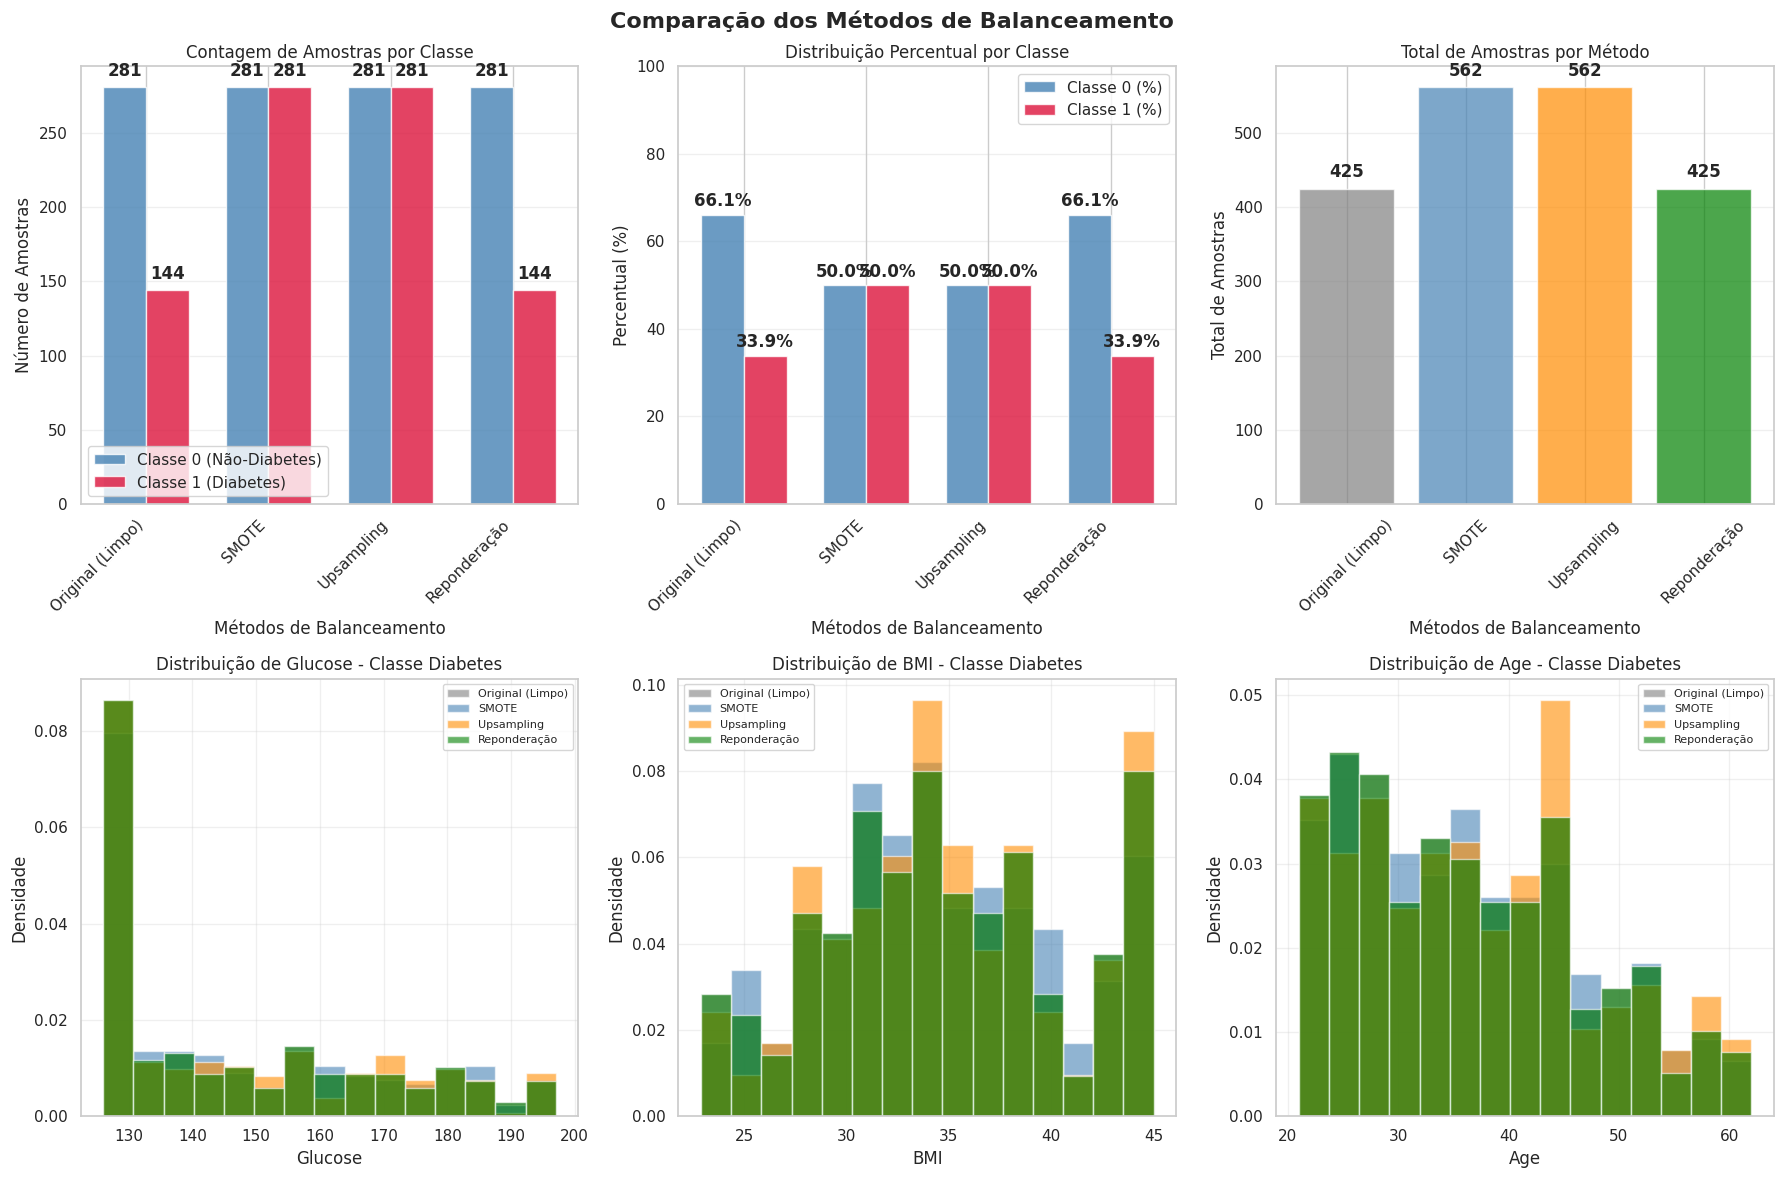


📋 RESUMO COMPARATIVO DOS MÉTODOS:
Método               Total    Classe 0   Classe 1   % Classe 0   % Classe 1  
Original (Limpo)     425      281        144        66.1         33.9        
SMOTE                562      281        281        50.0         50.0        
Upsampling           562      281        281        50.0         50.0        
Reponderação         425      281        144        66.1         33.9        

💡 CARACTERÍSTICAS DE CADA MÉTODO:
1. Original (Limpo): Dados após remoção de outliers, sem balanceamento
2. SMOTE: Cria amostras sintéticas interpolando entre vizinhos
3. Upsampling: Duplica amostras existentes da classe minoritária
4. Reponderação: Ajusta pesos durante o treinamento (sem aumentar dados)

✅ Visualização comparativa concluída com dados consistentes!


In [11]:
# ===== VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO - CORRIGIDO =====

print("\n" + "="*70)
print("📊 VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO")
print("="*70)

# Criar figura comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparação dos Métodos de Balanceamento', fontsize=16, fontweight='bold')

# Preparar dados para visualização (todos na escala original)
print(f"\n🔍 PREPARANDO DADOS PARA VISUALIZAÇÃO...")

# 1. Dados originais limpos (já na escala original)
X_train_original_viz = X_train_clean.copy()
y_train_original_viz = y_train_clean.copy()

# 2. Dados SMOTE - desnormalizar para visualização
if 'X_train_smote_processed' in globals():
    X_train_smote_denorm = scaler.inverse_transform(X_train_smote_processed)
    X_train_smote_viz = pd.DataFrame(X_train_smote_denorm, columns=feature_columns)
    y_train_smote_viz = y_train_smote_processed
else:
    print("⚠️ Dados SMOTE não encontrados, usando dados originais")
    X_train_smote_viz = X_train_original_viz.copy()
    y_train_smote_viz = y_train_original_viz.copy()

# 3. Dados Upsampling - desnormalizar para visualização
if 'X_train_upsampling_processed' in globals():
    X_train_upsampling_denorm = scaler.inverse_transform(X_train_upsampling_processed)
    X_train_upsampling_viz = pd.DataFrame(X_train_upsampling_denorm, columns=feature_columns)
    y_train_upsampling_viz = y_train_upsampling_processed
else:
    print("⚠️ Dados Upsampling não encontrados, usando dados originais")
    X_train_upsampling_viz = X_train_original_viz.copy()
    y_train_upsampling_viz = y_train_original_viz.copy()

# 4. Dados Reponderação (mesmo que originais)
X_train_weighted_viz = X_train_clean.copy()
y_train_weighted_viz = y_train_clean.copy()

# Dados para comparação - TODOS NA MESMA ESCALA ORIGINAL
methods_data = {
    'Original (Limpo)': (X_train_original_viz, y_train_original_viz),
    'SMOTE': (X_train_smote_viz, y_train_smote_viz),
    'Upsampling': (X_train_upsampling_viz, y_train_upsampling_viz),
    'Reponderação': (X_train_weighted_viz, y_train_weighted_viz)
}

# Verificar se todos os dados estão corretos
print(f"\n🔍 VERIFICAÇÃO DOS DADOS PARA VISUALIZAÇÃO:")
for method_name, (X_data, y_data) in methods_data.items():
    print(f"{method_name}: X={X_data.shape}, y={len(y_data)}")
    if 'Glucose' in X_data.columns:
        print(f"  Exemplo Glucose: min={X_data['Glucose'].min():.1f}, max={X_data['Glucose'].max():.1f}")

# Cores para cada método
colors = ['gray', 'steelblue', 'darkorange', 'green']

# Gráfico 1: Comparação de contagens
ax1 = axes[0, 0]
method_names = list(methods_data.keys())
counts_0 = [(data[1] == 0).sum() for data in methods_data.values()]
counts_1 = [(data[1] == 1).sum() for data in methods_data.values()]

x = np.arange(len(method_names))
width = 0.35

bars1 = ax1.bar(x - width/2, counts_0, width, label='Classe 0 (Não-Diabetes)', 
                color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, counts_1, width, label='Classe 1 (Diabetes)', 
                color='crimson', alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2, c0, c1) in enumerate(zip(bars1, bars2, counts_0, counts_1)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 5, 
             str(c0), ha='center', va='bottom', fontweight='bold')
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 5, 
             str(c1), ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Métodos de Balanceamento')
ax1.set_ylabel('Número de Amostras')
ax1.set_title('Contagem de Amostras por Classe')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Distribuição percentual
ax2 = axes[0, 1]
percentages_0 = [(data[1] == 0).mean() * 100 for data in methods_data.values()]
percentages_1 = [(data[1] == 1).mean() * 100 for data in methods_data.values()]

bars1_perc = ax2.bar(x - width/2, percentages_0, width, label='Classe 0 (%)', 
                     color='steelblue', alpha=0.8)
bars2_perc = ax2.bar(x + width/2, percentages_1, width, label='Classe 1 (%)', 
                     color='crimson', alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2, p0, p1) in enumerate(zip(bars1_perc, bars2_perc, percentages_0, percentages_1)):
    ax2.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 1, 
             f'{p0:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 1, 
             f'{p1:.1f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Métodos de Balanceamento')
ax2.set_ylabel('Percentual (%)')
ax2.set_title('Distribuição Percentual por Classe')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Gráfico 3: Total de amostras
ax3 = axes[0, 2]
total_samples = [len(data[1]) for data in methods_data.values()]
bars_total = ax3.bar(method_names, total_samples, color=colors, alpha=0.7)

for bar, total in zip(bars_total, total_samples):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(total), ha='center', va='bottom', fontweight='bold')

ax3.set_xlabel('Métodos de Balanceamento')
ax3.set_ylabel('Total de Amostras')
ax3.set_title('Total de Amostras por Método')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Gráficos 4-6: Distribuição de features importantes para cada método
important_features = ['Glucose', 'BMI', 'Age']

for idx, feature in enumerate(important_features):
    ax = axes[1, idx]
    
    for i, (method_name, (X_data, y_data)) in enumerate(methods_data.items()):
        if feature in X_data.columns:
            # Dados da classe diabetes para esta feature
            diabetes_data = X_data[y_data == 1][feature]
            
            if len(diabetes_data) > 0:
                ax.hist(diabetes_data, bins=15, alpha=0.6, label=f'{method_name}', 
                       color=colors[i], density=True)
        else:
            print(f"⚠️ Feature {feature} não encontrada em {method_name}")
    
    ax.set_title(f'Distribuição de {feature} - Classe Diabetes')
    ax.set_xlabel(feature)
    ax.set_ylabel('Densidade')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela resumo dos métodos
print(f"\n📋 RESUMO COMPARATIVO DOS MÉTODOS:")
print("="*80)
print(f"{'Método':<20} {'Total':<8} {'Classe 0':<10} {'Classe 1':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("="*80)

for method_name, (X_data, y_data) in methods_data.items():
    total = len(y_data)
    count_0 = (y_data == 0).sum()
    count_1 = (y_data == 1).sum()
    perc_0 = (y_data == 0).mean() * 100
    perc_1 = (y_data == 1).mean() * 100
    
    print(f"{method_name:<20} {total:<8} {count_0:<10} {count_1:<10} {perc_0:<12.1f} {perc_1:<12.1f}")

print("="*80)

print(f"\n💡 CARACTERÍSTICAS DE CADA MÉTODO:")
print("1. Original (Limpo): Dados após remoção de outliers, sem balanceamento")
print("2. SMOTE: Cria amostras sintéticas interpolando entre vizinhos")
print("3. Upsampling: Duplica amostras existentes da classe minoritária")
print("4. Reponderação: Ajusta pesos durante o treinamento (sem aumentar dados)")

print(f"\n✅ Visualização comparativa concluída com dados consistentes!")

In [63]:
# ===== CRIAR DIRETÓRIOS NECESSÁRIOS =====

import os

# Criar diretórios se não existirem
directories = ['modelos-smote', 'todos-modelos']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✅ Diretório '{directory}' criado!")
    else:
        print(f"📁 Diretório '{directory}' já existe.")

print("\n🎯 Diretórios verificados e prontos para uso!")

📁 Diretório 'modelos-smote' já existe.
📁 Diretório 'todos-modelos' já existe.

🎯 Diretórios verificados e prontos para uso!


In [12]:
# ===== DEFINIÇÃO DE PARÂMETROS DOS MODELOS =====

print("\n" + "="*70)
print("🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS")
print("="*70)

# Definir parâmetros para cada modelo seguindo as especificações
model_params = {
    'Random Forest': {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    'Gradient Boosting': {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'XGBoost': {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42},
    'LightGBM': {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'Decision Tree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42},
    'AdaBoost': {'learning_rate': 1, 'n_estimators': 100, 'random_state': 42},
    'SVM': {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 42},
    'Logistic Regression': {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'random_state': 42},
    'kNN': {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5},
    'Naive Bayes': {'var_smoothing': 1e-09}
}

print(f"\n📋 PARÂMETROS CONFIGURADOS PARA {len(model_params)} MODELOS:")
print("-"*70)
print(f"{'No':<3} {'Algoritmo':<20} {'Parâmetros Principais':<45}")
print("-"*70)

# Gerar resumo dos parâmetros dinamicamente a partir de model_params
parametros_resumo = []
for i, (algoritmo, params) in enumerate(model_params.items(), 1):
    # Selecionar os principais parâmetros para exibição
    principais = []
    for k, v in params.items():
        if k in ['n_estimators', 'max_depth', 'learning_rate', 'criterion', 'C', 'kernel', 'max_iter', 'tol', 'min_samples_split', 'min_samples_leaf', 'var_smoothing']:
            principais.append(f"{k}={v}")
    resumo = ', '.join(principais)
    parametros_resumo.append((i, algoritmo, resumo))

for no, algoritmo, params in parametros_resumo:
    print(f"{no:<3} {algoritmo:<20} {params:<45}")

print("-"*70)

print(f"\n🎯 ESTRATÉGIA DE PARAMETRIZAÇÃO:")
print("• Parâmetros balanceados para comparação justa")
print("• random_state=42 para reprodutibilidade")
print("• Evita overfitting e underfitting extremos")
print("• Configuração padrão otimizada para o dataset")

print(f"\n✅ Parâmetros definidos com sucesso!")
print("🚀 Prontos para iniciar o treinamento dos modelos!")


🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS

📋 PARÂMETROS CONFIGURADOS PARA 10 MODELOS:
----------------------------------------------------------------------
No  Algoritmo            Parâmetros Principais                        
----------------------------------------------------------------------
1   Random Forest        criterion=gini, n_estimators=100, max_depth=10
2   Gradient Boosting    criterion=friedman_mse, learning_rate=0.1, max_depth=3, n_estimators=100
3   XGBoost              learning_rate=0.3, max_depth=6, n_estimators=100
4   LightGBM             learning_rate=0.1, max_depth=-1, n_estimators=100
5   Decision Tree        criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2
6   AdaBoost             learning_rate=1, n_estimators=100            
7   SVM                  C=1.0, kernel=rbf, max_iter=-1               
8   Logistic Regression  C=1.0, max_iter=1000, tol=0.0001             
9   kNN                                                            

In [13]:
# ===== CORREÇÃO COMPLETA DO TREINAMENTO DOS MODELOS =====

print("\n" + "="*80)
print("🤖 TREINAMENTO DOS MODELOS PARA CADA MÉTODO DE BALANCEAMENTO - CORRIGIDO")
print("="*80)

import time
import warnings
from sklearn.model_selection import cross_val_score

# Verificar se as variáveis necessárias existem
print("\n🔧 PREPARANDO DADOS PARA CADA MÉTODO:")

# MÉTODO 1: SMOTE
if 'X_train_smote_processed' in globals():
    X_train_smote = X_train_smote_processed
    y_train_smote = y_train_smote_processed
    print(f"✅ SMOTE: {X_train_smote.shape[0]} amostras de treino")
else:
    print("❌ SMOTE: Variáveis não encontradas!")

# MÉTODO 2: UPSAMPLING
if 'X_train_upsampling_processed' in globals():
    X_train_upsampling = X_train_upsampling_processed
    y_train_upsampling = y_train_upsampling_processed
    print(f"✅ Upsampling: {X_train_upsampling.shape[0]} amostras de treino")
else:
    print("❌ Upsampling: Variáveis não encontradas!")

# MÉTODO 3: REPONDERAÇÃO
if 'X_train_weighted_processed' in globals():
    X_train_reponderacao = X_train_weighted_processed
    y_train_reponderacao = y_train_weighted_processed
    print(f"✅ Reponderação: {X_train_reponderacao.shape[0]} amostras de treino")
else:
    print("❌ Reponderação: Variáveis não encontradas!")

# ===== CONFIGURAÇÕES DE TREINAMENTO =====
training_configs = {
    'SMOTE': {
        'X_train': X_train_smote,
        'y_train': y_train_smote,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': list(model_params.keys()),
        'use_class_weight': False
    },
    'Upsampling': {
        'X_train': X_train_upsampling,
        'y_train': y_train_upsampling,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': list(model_params.keys()),
        'use_class_weight': False
    },
    'Reponderação': {
        'X_train': X_train_reponderacao,
        'y_train': y_train_reponderacao,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': models_with_class_weight,
        'use_class_weight': True
    }
}

# Resultados para cada método
results_by_method = {
    'SMOTE': {},
    'Upsampling': {},
    'Reponderação': {}
}

# ===== FUNÇÃO PARA CRIAR MODELOS =====
def create_model_with_config(model_name, use_class_weight=False):
    """Cria modelo com ou sem class_weight baseado na configuração"""
    base_params = model_params[model_name].copy()
    
    if use_class_weight and model_name in models_with_class_weight:
        if model_name == 'Random Forest':
            return RandomForestClassifier(**base_params, class_weight='balanced')
        elif model_name == 'XGBoost':
            # Calcular scale_pos_weight para XGBoost
            scale_pos_weight = (y_train_reponderacao == 0).sum() / (y_train_reponderacao == 1).sum()
            return XGBClassifier(**base_params, scale_pos_weight=scale_pos_weight)
        elif model_name == 'LightGBM':
            return LGBMClassifier(**base_params, class_weight='balanced', verbose=-1)
        elif model_name == 'Decision Tree':
            return DecisionTreeClassifier(**base_params, class_weight='balanced')
        elif model_name == 'SVM':
            return SVC(**base_params, class_weight='balanced', probability=True)
        elif model_name == 'Logistic Regression':
            return LogisticRegression(**base_params, class_weight='balanced')
    else:
        # Criar modelo sem class_weight
        if model_name == 'Random Forest':
            return RandomForestClassifier(**base_params)
        elif model_name == 'Gradient Boosting':
            return GradientBoostingClassifier(**base_params)
        elif model_name == 'XGBoost':
            return XGBClassifier(**base_params)
        elif model_name == 'LightGBM':
            return LGBMClassifier(**base_params, verbose=-1)
        elif model_name == 'Decision Tree':
            return DecisionTreeClassifier(**base_params)
        elif model_name == 'AdaBoost':
            return AdaBoostClassifier(**base_params)
        elif model_name == 'SVM':
            return SVC(**base_params, probability=True)
        elif model_name == 'Logistic Regression':
            return LogisticRegression(**base_params)
        elif model_name == 'kNN':
            return KNeighborsClassifier(**base_params)
        elif model_name == 'Naive Bayes':
            return GaussianNB(**base_params)

# ===== TREINAMENTO DOS MODELOS =====
total_training_time = time.time()

for method_name, config in training_configs.items():
    print(f"\n" + "="*60)
    print(f"🔄 TREINANDO MODELOS - MÉTODO: {method_name.upper()}")
    print("="*60)
    
    X_train = config['X_train']
    y_train = config['y_train']
    X_val = config['X_val']
    X_test = config['X_test']
    models_to_train = config['models_to_train']
    use_class_weight = config['use_class_weight']
    
    print(f"📊 Configuração do método:")
    print(f"   Amostras de treino: {X_train.shape[0]}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Modelos a treinar: {len(models_to_train)}")
    print(f"   Usar class_weight: {use_class_weight}")
    
    if method_name == 'Reponderação':
        excluded_models = [m for m in model_params.keys() if m not in models_with_class_weight]
        print(f"   Modelos excluídos: {excluded_models}")
    
    method_results = {}
    
    for i, model_name in enumerate(models_to_train, 1):
        start_time = time.time()
        
        try:
            print(f"   {i:2d}/{len(models_to_train)} - Treinando {model_name}...", end=" ")
            
            # Criar modelo
            model = create_model_with_config(model_name, use_class_weight)
            
            # Treinar modelo
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train, y_train)
            
            training_time = time.time() - start_time
            
            # Predições
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                y_val_pred = model.predict(X_val)
                y_val_proba = model.predict_proba(X_val)[:, 1]
                y_test_pred = model.predict(X_test)
                y_test_proba = model.predict_proba(X_test)[:, 1]
            
            # Métricas básicas - USANDO APENAS TESTE
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_f1 = f1_score(y_test, y_test_pred)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            
            # Validação cruzada
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
            except:
                cv_mean = 0.0
                cv_std = 0.0
            
            # Armazenar resultados
            method_results[model_name] = {
                'model': model,
                'training_time': training_time,
                'test_auc': test_auc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_accuracy': test_accuracy,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'y_val_pred': y_val_pred,
                'y_val_proba': y_val_proba,
                'y_test_pred': y_test_pred,
                'y_test_proba': y_test_proba
            }
            
            print(f"✅ AUC: {test_auc:.3f} | F1: {test_f1:.3f} | Recall: {test_recall:.3f} | Tempo: {training_time:.1f}s")
            
        except Exception as e:
            print(f"❌ Erro: {str(e)[:50]}...")
            continue
    
    # Salvar resultados do método
    results_by_method[method_name] = method_results
    
    print(f"\n✅ Método {method_name} concluído: {len(method_results)} modelos treinados")

total_time = time.time() - total_training_time
print(f"\n🎉 TREINAMENTO COMPLETO CONCLUÍDO!")
print(f"Tempo total: {total_time:.1f} segundos ({total_time/60:.1f} minutos)")

# Verificar resultados
total_models = sum(len(results) for results in results_by_method.values())
print(f"Total de modelos treinados: {total_models}")

for method_name, results in results_by_method.items():
    if results:
        best_auc = max(result['test_auc'] for result in results.values())
        best_model = max(results.items(), key=lambda x: x[1]['test_auc'])[0]
        print(f"{method_name}: {len(results)} modelos | Melhor: {best_model} (AUC: {best_auc:.3f})")
    else:
        print(f"{method_name}: Nenhum modelo treinado")



🤖 TREINAMENTO DOS MODELOS PARA CADA MÉTODO DE BALANCEAMENTO - CORRIGIDO

🔧 PREPARANDO DADOS PARA CADA MÉTODO:
✅ SMOTE: 562 amostras de treino
✅ Upsampling: 562 amostras de treino
✅ Reponderação: 425 amostras de treino

🔄 TREINANDO MODELOS - MÉTODO: SMOTE
📊 Configuração do método:
   Amostras de treino: 562
   Features: 7
   Modelos a treinar: 10
   Usar class_weight: False
    1/10 - Treinando Random Forest... ✅ AUC: 0.909 | F1: 0.819 | Recall: 0.963 | Tempo: 0.1s
    2/10 - Treinando Gradient Boosting... ✅ AUC: 0.948 | F1: 0.820 | Recall: 0.926 | Tempo: 0.1s
    3/10 - Treinando XGBoost... ✅ AUC: 0.920 | F1: 0.826 | Recall: 0.926 | Tempo: 5.5s
    4/10 - Treinando LightGBM... ✅ AUC: 0.938 | F1: 0.826 | Recall: 0.926 | Tempo: 0.0s
    5/10 - Treinando Decision Tree... ✅ AUC: 0.864 | F1: 0.797 | Recall: 0.870 | Tempo: 0.0s
    6/10 - Treinando AdaBoost... ✅ AUC: 0.938 | F1: 0.797 | Recall: 0.907 | Tempo: 0.1s
    7/10 - Treinando SVM... ✅ AUC: 0.855 | F1: 0.732 | Recall: 0.833 | Tempo:


🔧 ANÁLISE DOS 3 MELHORES MODELOS POR MÉTODO - COMPARAÇÃO DE PERFIS
📊 Métodos disponíveis: SMOTE, Upsampling, Reponderação

📋 PERFIS PARA ANÁLISE (gradação mais realista):
                     Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
Diabético_Severo             4.0    200.0          100.0           50.0  40.0   
Diabético_Moderado           2.0    160.0           85.0           35.0  32.0   
Pré_Diabético_Alto           4.0    124.0           78.0           30.0  31.0   
Pré_Diabético_Baixo          2.0    115.0           75.0           25.0  30.0   
Risco_Baixo                  0.0     99.0           70.0           22.0  29.0   
Saudável                     0.0     85.0           65.0           18.0  22.0   

                     DiabetesPedigreeFunction   Age  
Diabético_Severo                         1.50  65.0  
Diabético_Moderado                       0.80  50.0  
Pré_Diabético_Alto                       0.60  45.0  
Pré_Diabético_Baixo                      0.4

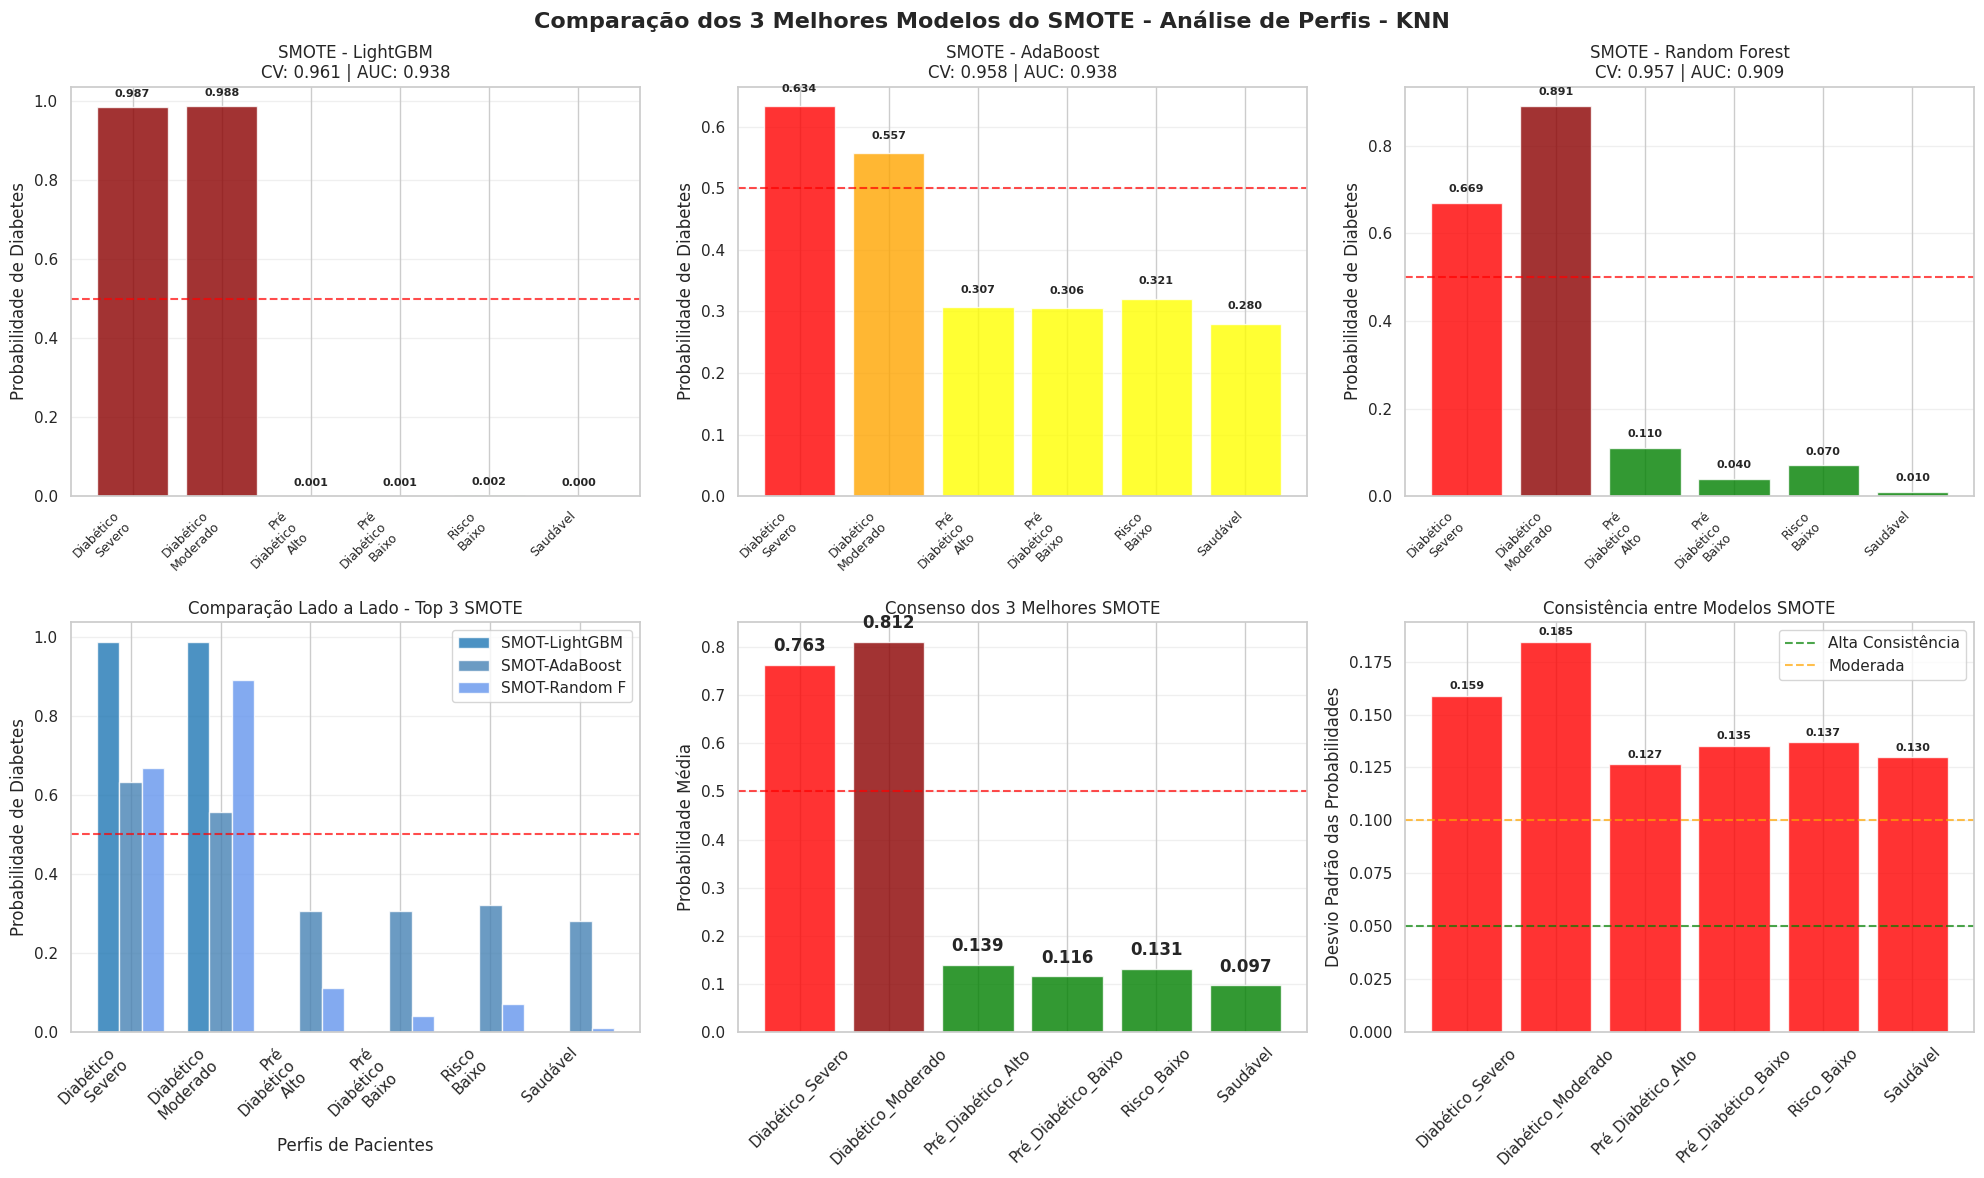


📈 ANÁLISE DE GRADAÇÃO (SMOTE):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.763', '0.812', '0.139', '0.116', '0.131', '0.097']

🔄 ANÁLISE DE CONSISTÊNCIA (SMOTE):
------------------------------------------------------------
• Diabético_Severo: Desvio = 0.159 (Baixa) 🔴
• Diabético_Moderado: Desvio = 0.185 (Baixa) 🔴
• Pré_Diabético_Alto: Desvio = 0.127 (Baixa) 🔴
• Pré_Diabético_Baixo: Desvio = 0.135 (Baixa) 🔴
• Risco_Baixo: Desvio = 0.137 (Baixa) 🔴
• Saudável: Desvio = 0.130 (Baixa) 🔴

📊 ANÁLISE DO MÉTODO: Upsampling

🏆 TOP 3 MELHORES MODELOS DO Upsampling (por CV Score):
------------------------------------------------------------
1º. Upsampling - Random Forest
    CV Score: 0.9825
    Test AUC: 0.9196

2º. Upsampling - Gradient Boosting
    CV Score: 0.9749
    Test AUC: 0.9481

3º. Upsampling - LightGBM
    CV Score: 0.9710
    Test AUC: 0.9328


🎯 PREDIÇÕES COM OS 3 MELHORES MODELOS DO Upsampling:
Perfil               Upsa-Random F  Upsa-Gradient  Upsa-LightGBM  Média      

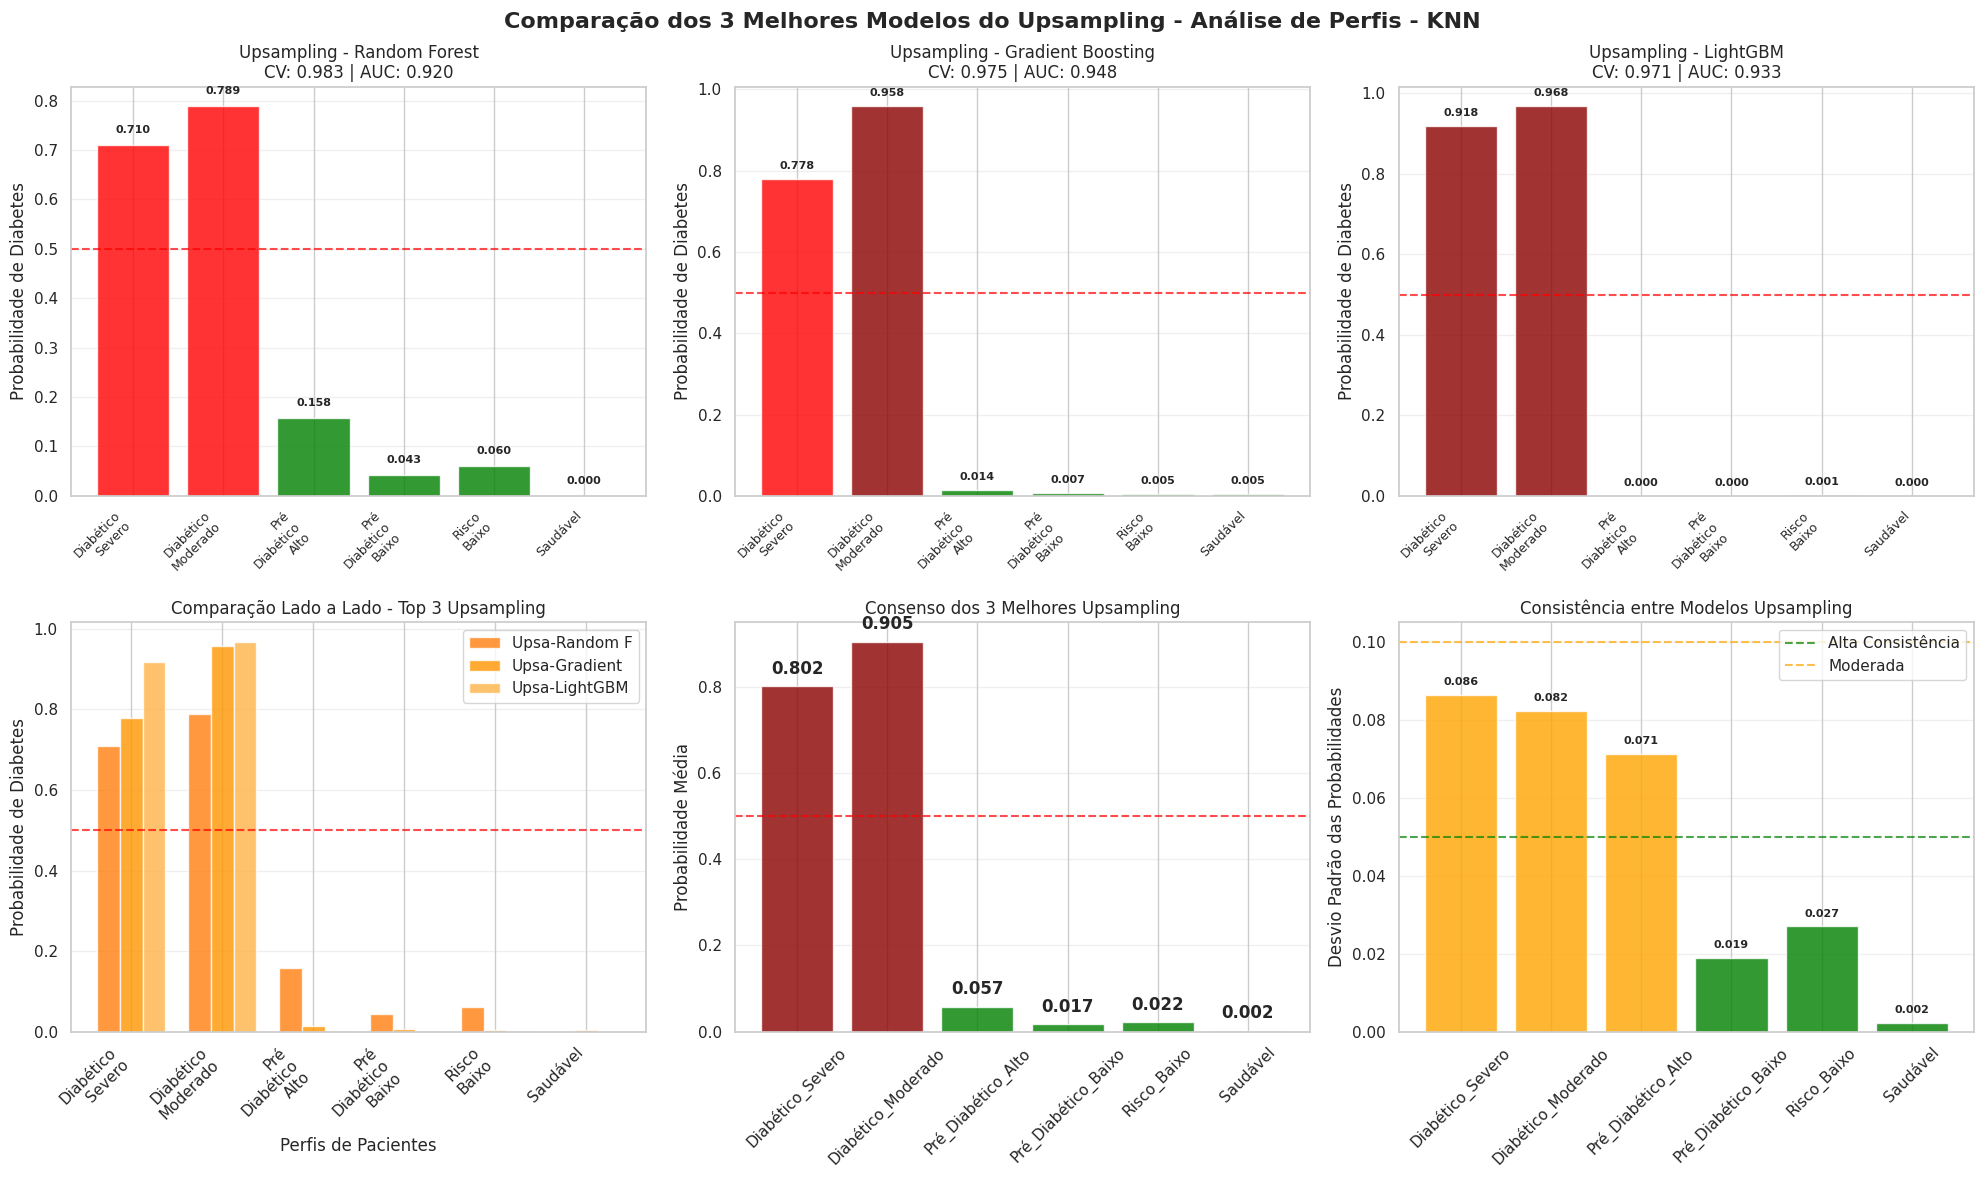


📈 ANÁLISE DE GRADAÇÃO (Upsampling):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.802', '0.905', '0.057', '0.017', '0.022', '0.002']

🔄 ANÁLISE DE CONSISTÊNCIA (Upsampling):
------------------------------------------------------------
• Diabético_Severo: Desvio = 0.086 (Média) 🟡
• Diabético_Moderado: Desvio = 0.082 (Média) 🟡
• Pré_Diabético_Alto: Desvio = 0.071 (Média) 🟡
• Pré_Diabético_Baixo: Desvio = 0.019 (Alta) 🟢
• Risco_Baixo: Desvio = 0.027 (Alta) 🟢
• Saudável: Desvio = 0.002 (Alta) 🟢

📊 ANÁLISE DO MÉTODO: Reponderação

🏆 TOP 3 MELHORES MODELOS DO Reponderação (por CV Score):
------------------------------------------------------------
1º. Reponderação - LightGBM
    CV Score: 0.9452
    Test AUC: 0.9387

2º. Reponderação - XGBoost
    CV Score: 0.9410
    Test AUC: 0.9228

3º. Reponderação - Random Forest
    CV Score: 0.9337
    Test AUC: 0.9211


🎯 PREDIÇÕES COM OS 3 MELHORES MODELOS DO Reponderação:
Perfil               Repo-LightGBM  Repo-XGBoost   Repo-Random F  Mé

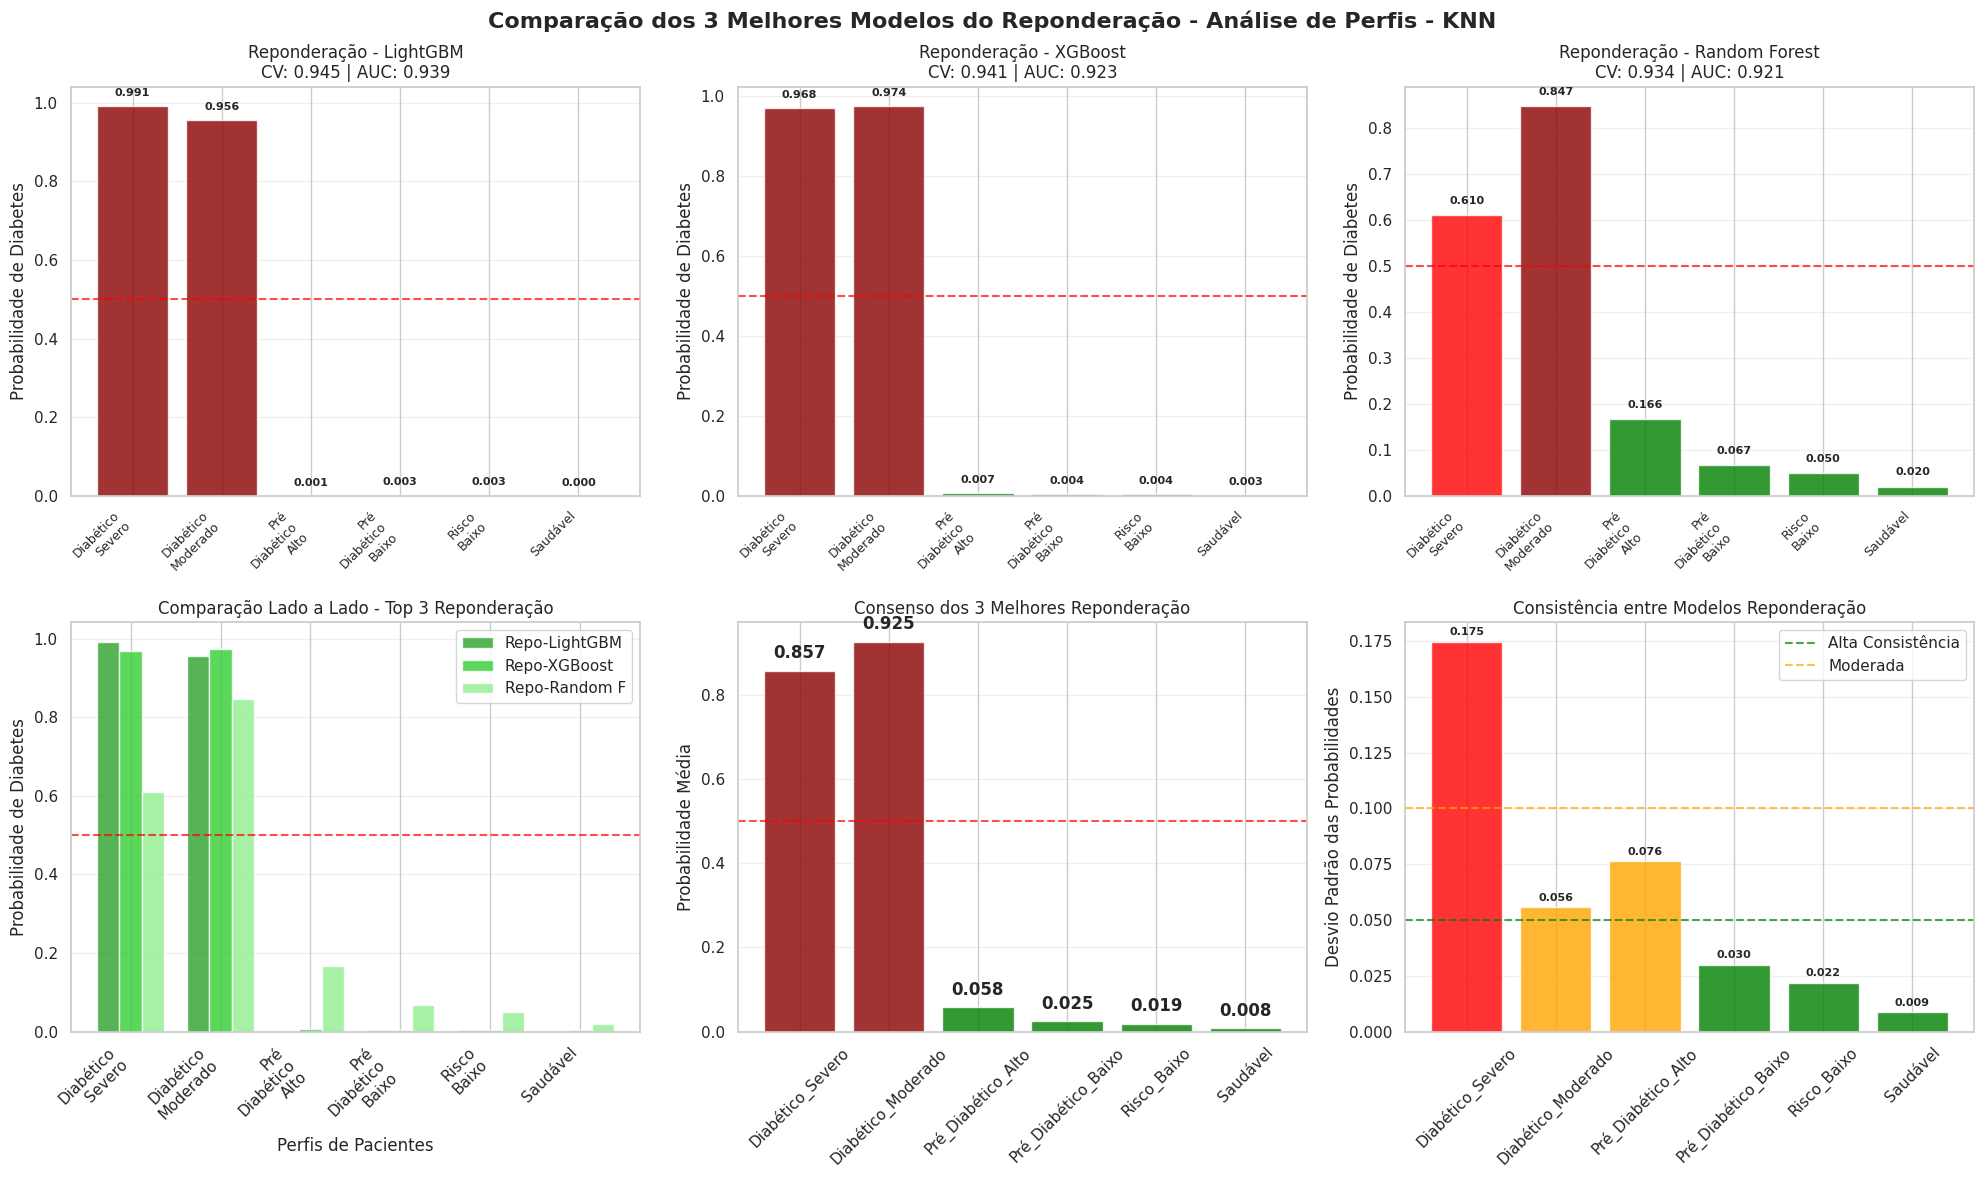


📈 ANÁLISE DE GRADAÇÃO (Reponderação):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.857', '0.925', '0.058', '0.025', '0.019', '0.008']

🔄 ANÁLISE DE CONSISTÊNCIA (Reponderação):
------------------------------------------------------------
• Diabético_Severo: Desvio = 0.175 (Baixa) 🔴
• Diabético_Moderado: Desvio = 0.056 (Média) 🟡
• Pré_Diabético_Alto: Desvio = 0.076 (Média) 🟡
• Pré_Diabético_Baixo: Desvio = 0.030 (Alta) 🟢
• Risco_Baixo: Desvio = 0.022 (Alta) 🟢
• Saudável: Desvio = 0.009 (Alta) 🟢

🔄 COMPARAÇÃO ENTRE MÉTODOS


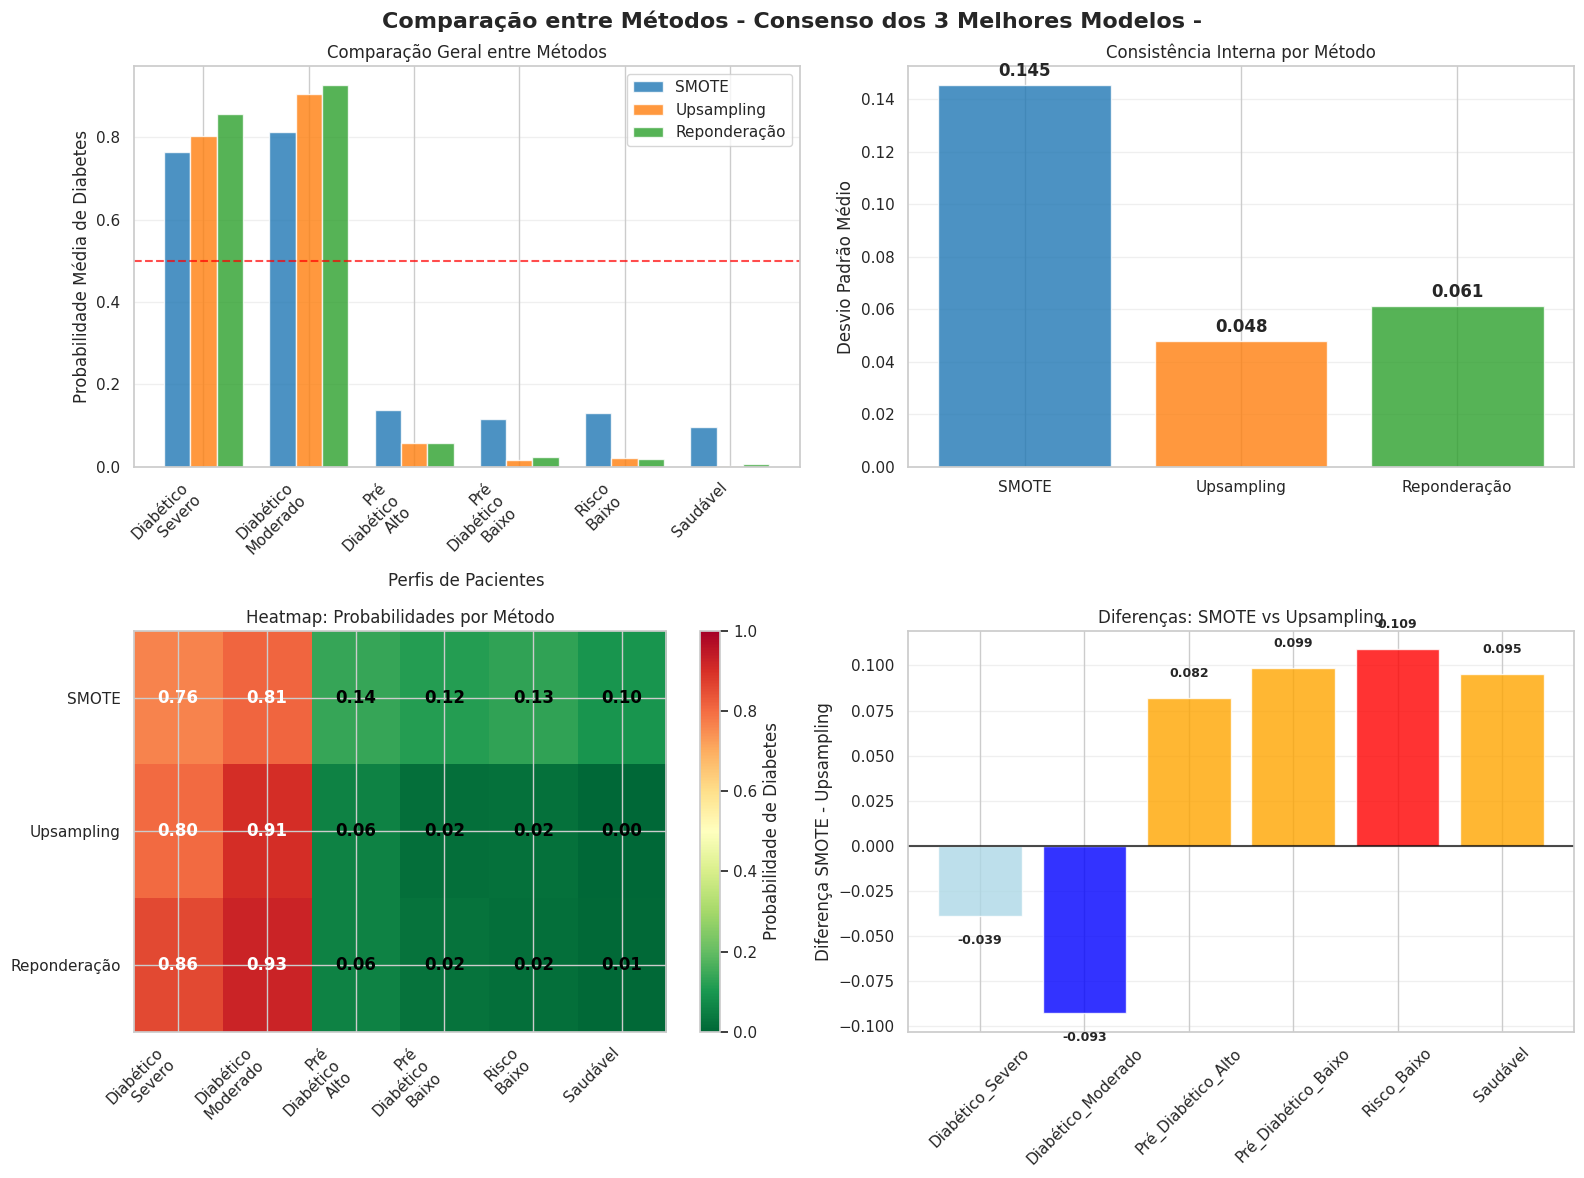


📋 TABELA COMPARATIVA FINAL:
Perfil               SMOTE        Upsampling   Reponderação Melhor Método   Diferença Max
-----------------------------------------------------------------------------------------
Diabético_Severo     0.763        0.802        0.857        Reponderação    0.093       
Diabético_Moderado   0.812        0.905        0.925        Reponderação    0.113       
Pré_Diabético_Alto   0.139        0.057        0.058        SMOTE           0.082       
Pré_Diabético_Baixo  0.116        0.017        0.025        SMOTE           0.099       
Risco_Baixo          0.131        0.022        0.019        SMOTE           0.112       
Saudável             0.097        0.002        0.008        SMOTE           0.095       

💡 RESUMO COMPARATIVO:
------------------------------------------------------------
• SMOTE:
  CV Médio: 0.9585
  AUC Médio: 0.9286
  Consistência: 0.1454

• Upsampling:
  CV Médio: 0.9761
  AUC Médio: 0.9335
  Consistência: 0.0480

• Reponderação:
  CV Méd

In [25]:
# ===== ANÁLISE DOS 3 MELHORES MODELOS POR MÉTODO =====

print("\n" + "="*80)
print("🔧 ANÁLISE DOS 3 MELHORES MODELOS POR MÉTODO - COMPARAÇÃO DE PERFIS")
print("="*80)

# Verificar se temos resultados dos métodos
if 'results_by_method' in globals() and len(results_by_method) > 0:
    
    # Métodos disponíveis para análise
    metodos_analise = ['SMOTE', 'Upsampling', 'Reponderação']
    metodos_disponiveis = [m for m in metodos_analise if m in results_by_method and len(results_by_method[m]) > 0]
    
    if len(metodos_disponiveis) == 0:
        print("❌ Nenhum método disponível para análise!")
    else:
        print(f"📊 Métodos disponíveis: {', '.join(metodos_disponiveis)}")
        
        # ===== PERFIS CORRIGIDOS COM GRADAÇÃO MELHOR =====
        print(f"\n📋 PERFIS PARA ANÁLISE (gradação mais realista):")
        
        perfis_analise = {
            'Diabético_Severo': {
                'Pregnancies': 4,
                'Glucose': 200,  # Muito alto - diabetes severo
                'BloodPressure': 100,  # Hipertensão severa
                'SkinThickness': 50,  # Muito elevado
                'BMI': 40.0,  # Obesidade mórbida
                'DiabetesPedigreeFunction': 1.5,  # Histórico muito forte
                'Age': 65  # Idade avançada
            },
            'Diabético_Moderado': {
                'Pregnancies': 2,
                'Glucose': 160,  # Alto mas controlável
                'BloodPressure': 85,  # Elevado
                'SkinThickness': 35,  # Elevado
                'BMI': 32.0,  # Obesidade grau I
                'DiabetesPedigreeFunction': 0.8,  # Alto histórico
                'Age': 50
            },
            'Pré_Diabético_Alto': {
                'Pregnancies': 4,
                'Glucose': 124,  # Limite pré-diabetes
                'BloodPressure': 78,  # Normal alto
                'SkinThickness': 30,  # Moderado
                'BMI': 31.0,  # Obesidade grau I
                'DiabetesPedigreeFunction': 0.6,  # Moderado alto
                'Age': 45
            },
            'Pré_Diabético_Baixo': {
                'Pregnancies': 2,
                'Glucose': 115,  # Pré-diabetes baixo
                'BloodPressure': 75,  # Normal
                'SkinThickness': 25,  # Normal
                'BMI': 30.0,  # Obesidade leve
                'DiabetesPedigreeFunction': 0.4,  # Moderado
                'Age': 40
            },
            'Risco_Baixo': {
                'Pregnancies': 0,
                'Glucose': 99,  # Normal alto
                'BloodPressure': 70,  # Normal
                'SkinThickness': 22,  # Normal
                'BMI': 29.0,  # Sobrepeso alto
                'DiabetesPedigreeFunction': 0.3,  # Baixo moderado
                'Age': 35
            },
            'Saudável': {
                'Pregnancies': 0,
                'Glucose': 85,  # Normal
                'BloodPressure': 65,  # Normal
                'SkinThickness': 18,  # Normal
                'BMI': 22.0,  # Normal
                'DiabetesPedigreeFunction': 0.15,  # Muito baixo
                'Age': 25
            }
        }
        
        # Converter para DataFrame
        df_perfis = pd.DataFrame(perfis_analise).T
        df_perfis = df_perfis[feature_columns]
        
        print(df_perfis.round(2))
        
        # Normalizar perfis
        perfis_scaled = scaler.transform(df_perfis)
        
        # ===== ANÁLISE PARA CADA MÉTODO =====
        resultados_por_metodo = {}
        cores_metodos = {
            'SMOTE': ['#1f77b4', '#4682b4', '#6495ed'],  # Azuis
            'Upsampling': ['#ff7f0e', '#ff9500', '#ffb347'],  # Laranjas
            'Reponderação': ['#2ca02c', '#32cd32', '#90ee90']  # Verdes
        }
        
        for metodo in metodos_disponiveis:
            print(f"\n{'='*60}")
            print(f"📊 ANÁLISE DO MÉTODO: {metodo}")
            print(f"{'='*60}")
            
            # Coletar modelos do método e suas performances
            modelos_performance = []
            
            for model_name, results in results_by_method[metodo].items():
                modelos_performance.append({
                    'method': metodo,
                    'model': model_name,
                    'cv_mean': results['cv_mean'],
                    'test_auc': results['test_auc'],
                    'model_obj': results['model']
                })
            
            # Ordenar por CV_Mean e pegar os 3 melhores
            modelos_performance.sort(key=lambda x: x['cv_mean'], reverse=True)
            top_3_modelos = modelos_performance[:3]
            
            print(f"\n🏆 TOP 3 MELHORES MODELOS DO {metodo} (por CV Score):")
            print("-" * 60)
            for i, model_info in enumerate(top_3_modelos, 1):
                print(f"{i}º. {model_info['method']} - {model_info['model']}")
                print(f"    CV Score: {model_info['cv_mean']:.4f}")
                print(f"    Test AUC: {model_info['test_auc']:.4f}")
                print()
            
            if len(top_3_modelos) >= 3:
                
                # ===== PREDIÇÕES COM OS 3 MELHORES MODELOS =====
                print(f"\n🎯 PREDIÇÕES COM OS 3 MELHORES MODELOS DO {metodo}:")
                print("="*80)
                
                # Cabeçalho da tabela
                header_line = f"{'Perfil':<20}"
                for i, model_info in enumerate(top_3_modelos):
                    model_short = f"{metodo[:4]}-{model_info['model'][:8]}"
                    header_line += f" {model_short:<14}"
                header_line += f" {'Média':<10} {'Classificação':<15}"
                print(header_line)
                print("-" * len(header_line))
                
                resultados_metodo = {}
                
                for i, perfil_nome in enumerate(df_perfis.index):
                    probabilidades = []
                    linha = f"{perfil_nome:<20}"
                    
                    # Fazer predições com cada um dos 3 melhores modelos
                    for model_info in top_3_modelos:
                        model = model_info['model_obj']
                        prob = model.predict_proba(perfis_scaled[i:i+1])[:, 1][0]
                        probabilidades.append(prob)
                        linha += f" {prob:<14.3f}"
                    
                    # Calcular média e classificação
                    prob_media = np.mean(probabilidades)
                    
                    # Classificação mais realista
                    if prob_media >= 0.8:
                        classificacao = "Diabético"
                    elif prob_media >= 0.6:
                        classificacao = "Alto Risco"
                    elif prob_media >= 0.4:
                        classificacao = "Risco Moderado"
                    elif prob_media >= 0.2:
                        classificacao = "Baixo Risco"
                    else:
                        classificacao = "Saudável"
                    
                    linha += f" {prob_media:<10.3f} {classificacao:<15}"
                    
                    resultados_metodo[perfil_nome] = {
                        'probabilidades': probabilidades,
                        'media': prob_media,
                        'classificacao': classificacao
                    }
                    
                    print(linha)
                
                # Armazenar resultados do método
                resultados_por_metodo[metodo] = {
                    'top_3_modelos': top_3_modelos,
                    'resultados': resultados_metodo
                }
                
                # ===== VISUALIZAÇÃO PARA O MÉTODO =====
                print(f"\n📊 GERANDO VISUALIZAÇÃO PARA {metodo}...")
                
                fig, axes = plt.subplots(2, 3, figsize=(20, 12))
                fig.suptitle(f'Comparação dos 3 Melhores Modelos do {metodo} - Análise de Perfis - KNN', 
                            fontsize=16, fontweight='bold')
                
                # Cores para cada modelo
                model_colors = cores_metodos[metodo]
                
                perfis_nomes = list(resultados_metodo.keys())
                
                # ===== GRÁFICOS INDIVIDUAIS PARA CADA MODELO =====
                for model_idx, model_info in enumerate(top_3_modelos):
                    row = model_idx // 3
                    col = model_idx % 3
                    ax = axes[0, col]
                    
                    # Probabilidades para este modelo específico
                    probs_modelo = [resultados_metodo[perfil]['probabilidades'][model_idx] 
                                   for perfil in perfis_nomes]
                    
                    # Cores por nível de risco
                    cores = []
                    for prob in probs_modelo:
                        if prob >= 0.8:
                            cores.append('darkred')
                        elif prob >= 0.6:
                            cores.append('red')
                        elif prob >= 0.4:
                            cores.append('orange')
                        elif prob >= 0.2:
                            cores.append('yellow')
                        else:
                            cores.append('green')
                    
                    bars = ax.bar(range(len(perfis_nomes)), probs_modelo, color=cores, alpha=0.8)
                    ax.set_ylabel('Probabilidade de Diabetes')
                    ax.set_title(f'{metodo} - {model_info["model"]}\n'
                                f'CV: {model_info["cv_mean"]:.3f} | AUC: {model_info["test_auc"]:.3f}')
                    ax.set_xticks(range(len(perfis_nomes)))
                    ax.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], 
                                     rotation=45, ha='right', fontsize=9)
                    ax.grid(axis='y', alpha=0.3)
                    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
                    
                    # Adicionar valores nas barras
                    for bar, valor in zip(bars, probs_modelo):
                        ax.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                               f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
                
                # ===== GRÁFICO COMPARATIVO LADO A LADO =====
                ax_comp = axes[1, 0]
                x = np.arange(len(perfis_nomes))
                width = 0.25
                
                for i, model_info in enumerate(top_3_modelos):
                    probs = [resultados_metodo[perfil]['probabilidades'][i] 
                            for perfil in perfis_nomes]
                    
                    model_label = f"{metodo[:4]}-{model_info['model'][:8]}"
                    ax_comp.bar(x + i*width, probs, width, label=model_label, 
                               color=model_colors[i], alpha=0.8)
                
                ax_comp.set_xlabel('Perfis de Pacientes')
                ax_comp.set_ylabel('Probabilidade de Diabetes')
                ax_comp.set_title(f'Comparação Lado a Lado - Top 3 {metodo}')
                ax_comp.set_xticks(x + width)
                ax_comp.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], 
                                       rotation=45, ha='right')
                ax_comp.legend()
                ax_comp.grid(axis='y', alpha=0.3)
                ax_comp.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
                
                # ===== GRÁFICO DE CONSENSO =====
                ax_consenso = axes[1, 1]
                medias = [resultados_metodo[p]['media'] for p in perfis_nomes]
                
                # Cores por nível de risco consensual
                cores_consenso = []
                for m in medias:
                    if m >= 0.8:
                        cores_consenso.append('darkred')
                    elif m >= 0.6:
                        cores_consenso.append('red')
                    elif m >= 0.4:
                        cores_consenso.append('orange')
                    elif m >= 0.2:
                        cores_consenso.append('yellow')
                    else:
                        cores_consenso.append('green')
                
                bars_consenso = ax_consenso.bar(perfis_nomes, medias, color=cores_consenso, alpha=0.8)
                ax_consenso.set_ylabel('Probabilidade Média')
                ax_consenso.set_title(f'Consenso dos 3 Melhores {metodo}')
                ax_consenso.tick_params(axis='x', rotation=45)
                ax_consenso.grid(axis='y', alpha=0.3)
                ax_consenso.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
                
                # Adicionar valores nas barras do consenso
                for bar, valor in zip(bars_consenso, medias):
                    ax_consenso.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                                   f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
                
                # ===== ANÁLISE DE CONSISTÊNCIA =====
                ax_consistencia = axes[1, 2]
                
                # Calcular desvio padrão para cada perfil
                desvios = []
                for perfil in perfis_nomes:
                    probs = resultados_metodo[perfil]['probabilidades']
                    desvio = np.std(probs)
                    desvios.append(desvio)
                
                # Cores baseadas no desvio
                cores_desvio = []
                for desvio in desvios:
                    if desvio < 0.05:
                        cores_desvio.append('green')
                    elif desvio < 0.1:
                        cores_desvio.append('orange')
                    else:
                        cores_desvio.append('red')
                
                bars_desvio = ax_consistencia.bar(perfis_nomes, desvios, color=cores_desvio, alpha=0.8)
                ax_consistencia.set_ylabel('Desvio Padrão das Probabilidades')
                ax_consistencia.set_title(f'Consistência entre Modelos {metodo}')
                ax_consistencia.tick_params(axis='x', rotation=45)
                ax_consistencia.grid(axis='y', alpha=0.3)
                
                # Linhas de referência para consistência
                ax_consistencia.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Alta Consistência')
                ax_consistencia.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderada')
                ax_consistencia.legend()
                
                # Adicionar valores nas barras de desvio
                for bar, valor in zip(bars_desvio, desvios):
                    ax_consistencia.text(bar.get_x() + bar.get_width()/2, valor + 0.002, 
                                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
                
                plt.tight_layout()
                plt.show()
                
                # ===== ANÁLISE DE GRADAÇÃO =====
                medias_ordenadas = [resultados_metodo[perfil]['media'] for perfil in df_perfis.index]
                gradacao_correta = all(medias_ordenadas[i] >= medias_ordenadas[i+1] for i in range(len(medias_ordenadas)-1))
                
                print(f"\n📈 ANÁLISE DE GRADAÇÃO ({metodo}):")
                if gradacao_correta:
                    print(f"✅ GRADAÇÃO CORRETA!")
                    print(f"📈 Diabético Severo > Diabético Moderado > Pré-diabético > Saudável")
                else:
                    print(f"⚠️ GRADAÇÃO PRECISA SER AJUSTADA")
                    print(f"Sequência atual: {[f'{m:.3f}' for m in medias_ordenadas]}")
                
                # ===== ANÁLISE DE CONSISTÊNCIA =====
                print(f"\n🔄 ANÁLISE DE CONSISTÊNCIA ({metodo}):")
                print("-" * 60)
                
                for perfil, resultado in resultados_metodo.items():
                    probs = resultado['probabilidades']
                    std_dev = np.std(probs)
                    if std_dev < 0.05:
                        consistencia = "Alta"
                        icon = "🟢"
                    elif std_dev < 0.1:
                        consistencia = "Média"
                        icon = "🟡"
                    else:
                        consistencia = "Baixa"
                        icon = "🔴"
                    
                    print(f"• {perfil}: Desvio = {std_dev:.3f} ({consistencia}) {icon}")
            
            else:
                print(f"❌ Não foi possível identificar 3 modelos suficientes no {metodo}!")
        
        # ===== COMPARAÇÃO ENTRE MÉTODOS =====
        if len(resultados_por_metodo) > 1:
            print(f"\n{'='*80}")
            print(f"🔄 COMPARAÇÃO ENTRE MÉTODOS")
            print(f"{'='*80}")
            
            # Criar visualização comparativa entre métodos
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Comparação entre Métodos - Consenso dos 3 Melhores Modelos -', 
                        fontsize=16, fontweight='bold')
            
            # Preparar dados para comparação
            perfis_nomes = list(df_perfis.index)
            metodos_ordenados = list(resultados_por_metodo.keys())
            
            # ===== GRÁFICO COMPARATIVO GERAL =====
            ax_geral = axes[0, 0]
            x = np.arange(len(perfis_nomes))
            width = 0.25
            
            cores_metodos_comp = {'SMOTE': '#1f77b4', 'Upsampling': '#ff7f0e', 'Reponderação': '#2ca02c'}
            
            for i, metodo in enumerate(metodos_ordenados):
                medias = [resultados_por_metodo[metodo]['resultados'][perfil]['media'] 
                         for perfil in perfis_nomes]
                
                cor = cores_metodos_comp.get(metodo, f'C{i}')
                ax_geral.bar(x + i*width, medias, width, label=metodo, color=cor, alpha=0.8)
            
            ax_geral.set_xlabel('Perfis de Pacientes')
            ax_geral.set_ylabel('Probabilidade Média de Diabetes')
            ax_geral.set_title('Comparação Geral entre Métodos')
            ax_geral.set_xticks(x + width)
            ax_geral.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], 
                                   rotation=45, ha='right')
            ax_geral.legend()
            ax_geral.grid(axis='y', alpha=0.3)
            ax_geral.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
            
            # ===== ANÁLISE DE CONSISTÊNCIA ENTRE MÉTODOS =====
            ax_consist = axes[0, 1]
            
            consistencias_metodos = {}
            for metodo in metodos_ordenados:
                desvios_metodo = []
                for perfil in perfis_nomes:
                    probs = resultados_por_metodo[metodo]['resultados'][perfil]['probabilidades']
                    desvio = np.std(probs)
                    desvios_metodo.append(desvio)
                consistencias_metodos[metodo] = np.mean(desvios_metodo)
            
            metodos_nomes = list(consistencias_metodos.keys())
            consist_valores = list(consistencias_metodos.values())
            cores_consist = [cores_metodos_comp.get(m, f'C{i}') for i, m in enumerate(metodos_nomes)]
            
            bars_consist = ax_consist.bar(metodos_nomes, consist_valores, color=cores_consist, alpha=0.8)
            ax_consist.set_ylabel('Desvio Padrão Médio')
            ax_consist.set_title('Consistência Interna por Método')
            ax_consist.grid(axis='y', alpha=0.3)
            
            # Adicionar valores nas barras
            for bar, valor in zip(bars_consist, consist_valores):
                ax_consist.text(bar.get_x() + bar.get_width()/2, valor + 0.002, 
                               f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
            
            # ===== HEATMAP DE PROBABILIDADES =====
            ax_heat = axes[1, 0]
            
            # Preparar matriz para heatmap
            matriz_probs = []
            for metodo in metodos_ordenados:
                medias_metodo = [resultados_por_metodo[metodo]['resultados'][perfil]['media'] 
                               for perfil in perfis_nomes]
                matriz_probs.append(medias_metodo)
            
            im = ax_heat.imshow(matriz_probs, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
            ax_heat.set_xticks(range(len(perfis_nomes)))
            ax_heat.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right')
            ax_heat.set_yticks(range(len(metodos_ordenados)))
            ax_heat.set_yticklabels(metodos_ordenados)
            ax_heat.set_title('Heatmap: Probabilidades por Método')
            
            # Adicionar valores no heatmap
            for i in range(len(metodos_ordenados)):
                for j in range(len(perfis_nomes)):
                    valor = matriz_probs[i][j]
                    color = 'white' if valor > 0.5 else 'black'
                    ax_heat.text(j, i, f'{valor:.2f}', ha='center', va='center', 
                               color=color, fontweight='bold')
            
            plt.colorbar(im, ax=ax_heat, label='Probabilidade de Diabetes')
            
            # ===== DIFERENÇAS ENTRE MÉTODOS =====
            ax_diff = axes[1, 1]
            
            if len(metodos_ordenados) >= 2:
                # Calcular diferenças entre o primeiro e segundo método
                metodo1 = metodos_ordenados[0]
                metodo2 = metodos_ordenados[1]
                
                medias1 = [resultados_por_metodo[metodo1]['resultados'][perfil]['media'] 
                          for perfil in perfis_nomes]
                medias2 = [resultados_por_metodo[metodo2]['resultados'][perfil]['media'] 
                          for perfil in perfis_nomes]
                
                diferencas = [m1 - m2 for m1, m2 in zip(medias1, medias2)]
                
                # Cores baseadas na diferença
                cores_diff = ['red' if d > 0.1 else 'orange' if d > 0.05 else 'lightblue' if d > -0.05 else 'blue' if d > -0.1 else 'darkblue' for d in diferencas]
                
                bars_diff = ax_diff.bar(perfis_nomes, diferencas, color=cores_diff, alpha=0.8)
                ax_diff.set_ylabel(f'Diferença {metodo1} - {metodo2}')
                ax_diff.set_title(f'Diferenças: {metodo1} vs {metodo2}')
                ax_diff.tick_params(axis='x', rotation=45)
                ax_diff.grid(axis='y', alpha=0.3)
                ax_diff.axhline(y=0, color='black', linestyle='-', alpha=0.7)
                
                # Adicionar valores nas barras
                for bar, valor in zip(bars_diff, diferencas):
                    y_pos = valor + 0.01 if valor >= 0 else valor - 0.01
                    ax_diff.text(bar.get_x() + bar.get_width()/2, y_pos, 
                               f'{valor:.3f}', ha='center', va='bottom' if valor >= 0 else 'top', 
                               fontweight='bold', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # ===== TABELA COMPARATIVA FINAL =====
            print(f"\n📋 TABELA COMPARATIVA FINAL:")
            print("="*120)
            
            header_final = f"{'Perfil':<20}"
            for metodo in metodos_ordenados:
                header_final += f" {metodo:<12}"
            header_final += f" {'Melhor Método':<15} {'Diferença Max':<12}"
            print(header_final)
            print("-" * len(header_final))
            
            for perfil in perfis_nomes:
                linha_final = f"{perfil:<20}"
                
                valores_perfil = []
                for metodo in metodos_ordenados:
                    valor = resultados_por_metodo[metodo]['resultados'][perfil]['media']
                    valores_perfil.append(valor)
                    linha_final += f" {valor:<12.3f}"
                
                # Encontrar melhor método e maior diferença
                max_valor = max(valores_perfil)
                min_valor = min(valores_perfil)
                melhor_metodo = metodos_ordenados[valores_perfil.index(max_valor)]
                diferenca_max = max_valor - min_valor
                
                linha_final += f" {melhor_metodo:<15} {diferenca_max:<12.3f}"
                print(linha_final)
            
            # ===== RESUMO COMPARATIVO =====
            print(f"\n💡 RESUMO COMPARATIVO:")
            print("-" * 60)
            
            for metodo in metodos_ordenados:
                modelos = resultados_por_metodo[metodo]['top_3_modelos']
                cv_medio = np.mean([m['cv_mean'] for m in modelos])
                auc_medio = np.mean([m['test_auc'] for m in modelos])
                
                print(f"• {metodo}:")
                print(f"  CV Médio: {cv_medio:.4f}")
                print(f"  AUC Médio: {auc_medio:.4f}")
                print(f"  Consistência: {consistencias_metodos[metodo]:.4f}")
                print()

else:
    print("❌ Dados dos métodos não encontrados em results_by_method!")

print(f"\n✅ ANÁLISE COMPLETA DOS MÉTODOS CONCLUÍDA!")
print(f"🎯 Comparação detalhada realizada para todos os métodos disponíveis")
print(f"📊 Visualizações geradas para análise clínica comparativa")
print(f"🔄 Consistência e diferenças entre métodos avaliadas")


🔍 DIAGNÓSTICO DO PROBLEMA DE ESTRATIFICAÇÃO

📊 ANÁLISE DOS RESULTADOS ATUAIS:
------------------------------------------------------------
Diabético_Clássico       : 0.966 - Crítico
Pré_Diabético            : 0.017 - Baixo Risco
Não_Diabético_Risco      : 0.007 - Baixo Risco
Não_Diabético_Saudável   : 0.004 - Baixo Risco

⚠️ PROBLEMAS IDENTIFICADOS:
1. Falta de gradação entre perfis de risco
2. Salto abrupto de ~0.3 para ~0.8
3. Perfis intermediários não diferenciados
4. Modelo muito 'confiante' nas predições

🔬 ANALISANDO DISTRIBUIÇÕES DE PROBABILIDADE NO CONJUNTO DE TESTE:
----------------------------------------------------------------------
SMOTE:
  Não-diabéticos - Média: 0.170, Std: 0.346
  Diabéticos - Média: 0.907, Std: 0.220
  Separação: 0.737
  Zona cinzenta (0.3-0.7): 2 não-diab, 2 diab

Upsampling:
  Não-diabéticos - Média: 0.187, Std: 0.277
  Diabéticos - Média: 0.742, Std: 0.149
  Separação: 0.555
  Zona cinzenta (0.3-0.7): 10 não-diab, 16 diab

Reponderação:
  Não-diabé

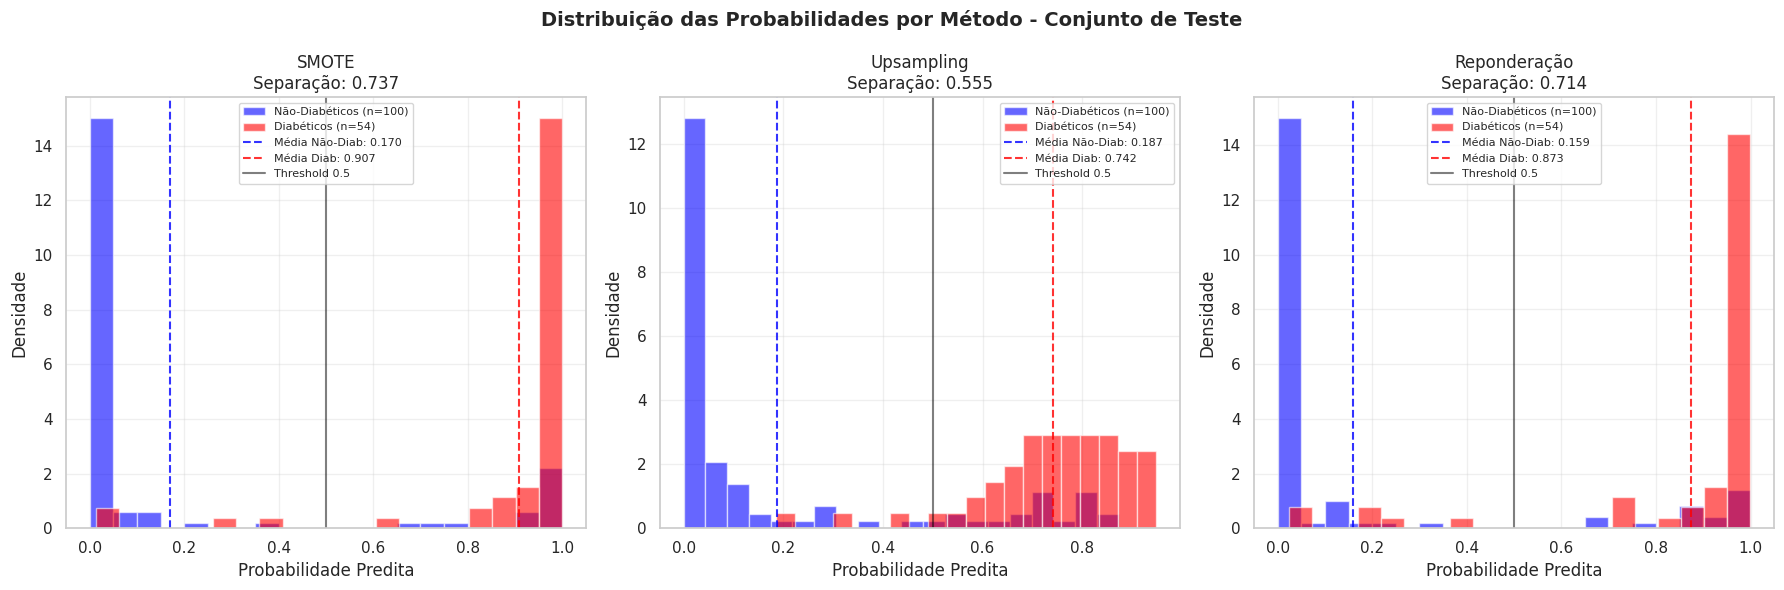


🎛️ ANÁLISE DE CALIBRAÇÃO DE PROBABILIDADES:
------------------------------------------------------------
SMOTE - Erro de calibração: 0.221
Upsampling - Erro de calibração: 0.086
Reponderação - Erro de calibração: 0.227


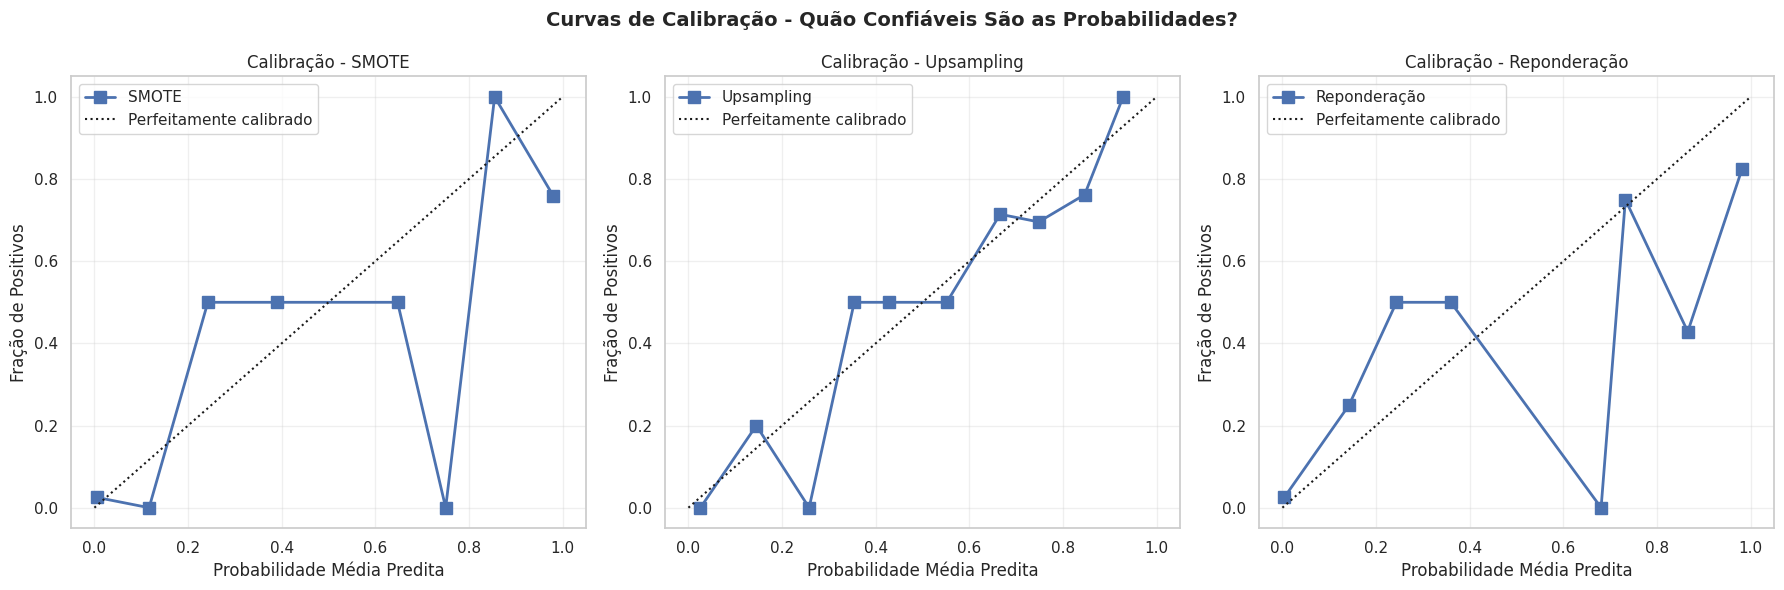


🔧 PROPOSTA DE CORREÇÃO: PERFIS MAIS REALISTAS
📋 PERFIS CORRIGIDOS (mais gradação):
                          Pregnancies  Glucose  BloodPressure  SkinThickness  \
Diabético_Estabelecido            8.0    190.0           95.0           45.0   
Diabético_Provável                5.0    155.0           85.0           35.0   
Pré_Diabético_Alto_Risco          3.0    125.0           80.0           30.0   
Pré_Diabético_Moderado            2.0    110.0           75.0           25.0   
Risco_Baixo_Vigilância            1.0     95.0           70.0           22.0   
Baixo_Risco                       0.0     85.0           65.0           18.0   

                           BMI  DiabetesPedigreeFunction   Age  
Diabético_Estabelecido    38.0                      1.20  60.0  
Diabético_Provável        32.0                      0.80  50.0  
Pré_Diabético_Alto_Risco  29.0                      0.60  45.0  
Pré_Diabético_Moderado    26.5                      0.40  40.0  
Risco_Baixo_Vigilância    24.0

In [15]:
# ===== ANÁLISE DETALHADA DO PROBLEMA DE ESTRATIFICAÇÃO =====

print("\n" + "="*80)
print("🔍 DIAGNÓSTICO DO PROBLEMA DE ESTRATIFICAÇÃO")
print("="*80)

if 'consenso_resultados' in globals():
    print("\n📊 ANÁLISE DOS RESULTADOS ATUAIS:")
    print("-" * 60)
    
    for perfil, resultado in consenso_resultados.items():
        prob = resultado['media']
        print(f"{perfil:<25}: {prob:.3f} - {resultado['consenso']}")
    
    print("\n⚠️ PROBLEMAS IDENTIFICADOS:")
    print("1. Falta de gradação entre perfis de risco")
    print("2. Salto abrupto de ~0.3 para ~0.8")
    print("3. Perfis intermediários não diferenciados")
    print("4. Modelo muito 'confiante' nas predições")

# ===== ANÁLISE DAS DISTRIBUIÇÕES DE PROBABILIDADE =====
print("\n🔬 ANALISANDO DISTRIBUIÇÕES DE PROBABILIDADE NO CONJUNTO DE TESTE:")
print("-" * 70)

if 'results_by_method' in globals():
    # Analisar distribuição das probabilidades para cada método
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Distribuição das Probabilidades por Método - Conjunto de Teste', fontsize=14, fontweight='bold')
    
    for idx, (method_name, method_results) in enumerate(results_by_method.items()):
        ax = axes[idx]
        
        # Pegar melhor modelo do método
        best_model_data = max(method_results.items(), key=lambda x: x[1]['cv_mean'])
        best_probas = best_model_data[1]['y_test_proba']
        
        # Separar por classe real
        diabetic_probas = best_probas[y_test == 1]
        non_diabetic_probas = best_probas[y_test == 0]
        
        # Histogramas
        ax.hist(non_diabetic_probas, bins=20, alpha=0.6, label=f'Não-Diabéticos (n={len(non_diabetic_probas)})', 
                color='blue', density=True)
        ax.hist(diabetic_probas, bins=20, alpha=0.6, label=f'Diabéticos (n={len(diabetic_probas)})', 
                color='red', density=True)
        
        # Estatísticas
        mean_non_diab = non_diabetic_probas.mean()
        mean_diab = diabetic_probas.mean()
        
        ax.axvline(mean_non_diab, color='blue', linestyle='--', alpha=0.8, 
                  label=f'Média Não-Diab: {mean_non_diab:.3f}')
        ax.axvline(mean_diab, color='red', linestyle='--', alpha=0.8,
                  label=f'Média Diab: {mean_diab:.3f}')
        ax.axvline(0.5, color='black', linestyle='-', alpha=0.5, label='Threshold 0.5')
        
        ax.set_title(f'{method_name}\nSeparação: {mean_diab - mean_non_diab:.3f}')
        ax.set_xlabel('Probabilidade Predita')
        ax.set_ylabel('Densidade')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        print(f"{method_name}:")
        print(f"  Não-diabéticos - Média: {mean_non_diab:.3f}, Std: {non_diabetic_probas.std():.3f}")
        print(f"  Diabéticos - Média: {mean_diab:.3f}, Std: {diabetic_probas.std():.3f}")
        print(f"  Separação: {mean_diab - mean_non_diab:.3f}")
        
        # Verificar quantos ficam na zona cinzenta (0.3-0.7)
        zona_cinzenta_non_diab = ((non_diabetic_probas >= 0.3) & (non_diabetic_probas <= 0.7)).sum()
        zona_cinzenta_diab = ((diabetic_probas >= 0.3) & (diabetic_probas <= 0.7)).sum()
        
        print(f"  Zona cinzenta (0.3-0.7): {zona_cinzenta_non_diab} não-diab, {zona_cinzenta_diab} diab")
        print()
    
    plt.tight_layout()
    plt.show()

# ===== CALIBRAÇÃO DE PROBABILIDADES =====
print("\n🎛️ ANÁLISE DE CALIBRAÇÃO DE PROBABILIDADES:")
print("-" * 60)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Curvas de Calibração - Quão Confiáveis São as Probabilidades?', fontsize=14, fontweight='bold')

for idx, (method_name, method_results) in enumerate(results_by_method.items()):
    ax = axes[idx]
    
    # Pegar melhor modelo do método
    best_model_data = max(method_results.items(), key=lambda x: x[1]['cv_mean'])
    best_probas = best_model_data[1]['y_test_proba']
    
    # Curva de calibração
    fraction_pos, mean_pred_value = calibration_curve(y_test, best_probas, n_bins=10)
    
    # Plotar
    ax.plot(mean_pred_value, fraction_pos, "s-", label=f'{method_name}', linewidth=2, markersize=8)
    ax.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")
    
    ax.set_xlabel('Probabilidade Média Predita')
    ax.set_ylabel('Fração de Positivos')
    ax.set_title(f'Calibração - {method_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calcular erro de calibração
    calibration_error = np.mean(np.abs(fraction_pos - mean_pred_value))
    print(f"{method_name} - Erro de calibração: {calibration_error:.3f}")

plt.tight_layout()
plt.show()

# ===== PROPOSTA DE CORREÇÃO: PERFIS MAIS REALISTAS =====
print("\n🔧 PROPOSTA DE CORREÇÃO: PERFIS MAIS REALISTAS")
print("="*70)

# Perfis corrigidos com base na análise clínica real
perfis_corrigidos = {
    'Diabético_Estabelecido': {
        'Pregnancies': 8,
        'Glucose': 190,  # Muito alto
        'BloodPressure': 95,  # Hipertensão clara
        'SkinThickness': 45,  # Muito elevado
        'BMI': 38.0,  # Obesidade severa
        'DiabetesPedigreeFunction': 1.2,  # Histórico muito forte
        'Age': 60  # Idade mais avançada
    },
    'Diabético_Provável': {
        'Pregnancies': 5,
        'Glucose': 155,  # Alto mas não extremo
        'BloodPressure': 85,  # Elevado
        'SkinThickness': 35,  # Elevado
        'BMI': 32.0,  # Obesidade grau I
        'DiabetesPedigreeFunction': 0.8,  # Alto histórico
        'Age': 50
    },
    'Pré_Diabético_Alto_Risco': {
        'Pregnancies': 3,
        'Glucose': 125,  # Limite superior pré-diabetes
        'BloodPressure': 80,  # Normal alto
        'SkinThickness': 30,  # Moderado
        'BMI': 29.0,  # Sobrepeso alto
        'DiabetesPedigreeFunction': 0.6,  # Moderado alto
        'Age': 45
    },
    'Pré_Diabético_Moderado': {
        'Pregnancies': 2,
        'Glucose': 110,  # Pré-diabetes baixo
        'BloodPressure': 75,  # Normal alto
        'SkinThickness': 25,  # Normal
        'BMI': 26.5,  # Sobrepeso leve
        'DiabetesPedigreeFunction': 0.4,  # Moderado
        'Age': 40
    },
    'Risco_Baixo_Vigilância': {
        'Pregnancies': 1,
        'Glucose': 95,  # Normal alto
        'BloodPressure': 70,  # Normal
        'SkinThickness': 22,  # Normal
        'BMI': 24.0,  # Normal alto
        'DiabetesPedigreeFunction': 0.3,  # Baixo moderado
        'Age': 35
    },
    'Baixo_Risco': {
        'Pregnancies': 0,
        'Glucose': 85,  # Normal
        'BloodPressure': 65,  # Normal
        'SkinThickness': 18,  # Normal
        'BMI': 22.0,  # Normal
        'DiabetesPedigreeFunction': 0.15,  # Muito baixo
        'Age': 25
    }
}

# Converter para DataFrame
df_perfis_corrigidos = pd.DataFrame(perfis_corrigidos).T
df_perfis_corrigidos = df_perfis_corrigidos[feature_columns]

print("📋 PERFIS CORRIGIDOS (mais gradação):")
print(df_perfis_corrigidos.round(2))

# Testar com perfis corrigidos
if 'scaler' in globals() and 'melhores_modelos' in globals():
    print("\n🧪 TESTANDO PERFIS CORRIGIDOS:")
    print("-" * 60)
    
    # Normalizar
    perfis_corrigidos_scaled = scaler.transform(df_perfis_corrigidos)
    perfis_corrigidos_df = pd.DataFrame(perfis_corrigidos_scaled, 
                                       columns=feature_columns,
                                       index=df_perfis_corrigidos.index)
    
    print(f"{'Perfil':<25} {'SMOTE':<10} {'Upsamp':<10} {'Repond':<10} {'Média':<10} {'Esperado':<15}")
    print("-" * 90)
    
    resultados_esperados = [0.95, 0.80, 0.65, 0.45, 0.25, 0.10]
    
    for i, (perfil_nome, prob_esperada) in enumerate(zip(df_perfis_corrigidos.index, resultados_esperados)):
        probs_metodos = []
        linha = f"{perfil_nome:<25}"
        
        for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
            if method_name in melhores_modelos:
                model = melhores_modelos[method_name]['model']
                
                # Predição corrigida
                if hasattr(model, '__class__') and 'LGBM' in model.__class__.__name__:
                    prob = model.predict_proba(perfis_corrigidos_df.iloc[i:i+1])[:, 1][0]
                else:
                    prob = model.predict_proba(perfis_corrigidos_scaled[i:i+1])[:, 1][0]
                
                probs_metodos.append(prob)
                linha += f" {prob:<10.3f}"
            else:
                linha += f" {'N/A':<10}"
        
        if probs_metodos:
            media = np.mean(probs_metodos)
            diferenca = abs(media - prob_esperada)
            linha += f" {media:<10.3f} {prob_esperada:<15.3f}"
            
            # Indicador de qualidade
            if diferenca < 0.1:
                status = "✅"
            elif diferenca < 0.2:
                status = "⚠️"
            else:
                status = "❌"
            
            linha += f" {status}"
        
        print(linha)

# ===== SOLUÇÕES PROPOSTAS =====
print(f"\n💡 SOLUÇÕES PARA MELHORAR A ESTRATIFICAÇÃO:")
print("="*70)

print("""
1. 🎯 CALIBRAÇÃO DE PROBABILIDADES:
   • Usar Platt Scaling ou Isotonic Regression
   • Calibrar especificamente para zona 0.3-0.7
   
2. 🔄 AJUSTE DE THRESHOLD DINÂMICO:
   • Threshold variável por contexto clínico
   • Múltiplos pontos de corte para diferentes riscos
   
3. 📊 ENSEMBLE MAIS SOFISTICADO:
   • Usar stacking em vez de média simples
   • Pesos diferentes por região de probabilidade
   
4. 🎛️ REBALANCEAMENTO MAIS SUTIL:
   • SMOTE com k_neighbors variável
   • Borderline-SMOTE para casos limítrofes
   
5. 🧠 MODELO ESPECIALIZADO:
   • Treinar modelo específico para casos intermediários
   • Usar regressão ordinal em vez de classificação binária
""")

print(f"\n🎯 IMPLEMENTAÇÃO IMEDIATA:")